<a href="https://colab.research.google.com/github/teaht/Masters_Thesis/blob/main/Domain_Adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Required Packages and Designate "Hand-Event" Pair for the Notebook**

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO
import plotly.express as px
import numpy as np
from IPython.display import Image   #Display images
import warnings                     #Ignore version warnings
warnings.simplefilter('ignore', FutureWarning)

Code book establishing event codes with their actual description.

Use this next cell lists the codes that corresponds to the different events:

*  Strikeouts: event_code = 4

*  Walks: event_code = 18

*  Hits: event_code = c(20, 21, 22, 23)

*  OBP: event_code = c(18, 20, 21, 22, 23)

*  HR: event_code = 23




In [ ]:
Strikeouts = [4,4.0,'4','4.0']

Walks = [18,18.0,'18','18.0']

Hits = [20, 20.0, '20', '20.0', 21, 21.0, '21', '21.0', 22, 22.0, '22', '22.0', 23, 23.0, '23', '23.0']

OBP = [18, 18.0, '18', '18.0', 20, 20.0, '20', '20.0', 21, 21.0, '21', '21.0', 22, 22.0, '22', '22.0', 23, 23.0, '23', '23.0']

HR = [23,23.0,'23','23.0']

In the next cell, let's choose the `Hand`: R or L and `event_code` that we'll use **throughout the notebook**

This will allow us to "set it and forget it", designating and running analysis for a given "Hand-Event" pair throughout the notebook.

In [ ]:
Hand = 'R'
event_code = Hits
event_code_text = "Hits"

# **Curate the Baseball Source Data**

Import the data

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
def read_google_sheet(sheet_id, sheet_name):
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    return pd.read_csv(url)

In [ ]:
baseball_sheet_id = '1H_g294-sN58ONfFGWTOKIYF3L13nsZem'
baseball_sheet_name = 'baseball'
baseball = read_google_sheet(baseball_sheet_id, baseball_sheet_name)
baseball

/tmp/ipython-input-3359265799.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(url)


,outcome,pitch_type,zone,stand,p_throws,balls,strikes,outs_when_up,inning,bat_score_diff,num_baserunners,home_vis,pitch_score,hitting_score,game_type,game_date
0,4,D,9.0,R,R,2,2,2,7,-1,0,V,1,0,R,2024-04-03
1,4,C,3.0,R,R,2,2,1,6,2,0,H,0,2,R,2024-04-03
2,2,C,5.0,R,R,1,2,2,6,-1,1,H,4,3,R,2024-04-03
3,18,D,7.0,R,R,3,1,2,6,-2,2,V,3,1,R,2024-04-03
4,4,C,9.0,L,R,2,2,1,7,-1,0,V,1,0,R,2024-04-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172323,2,X,9.0,L,R,0,1,2,7,-1,2,V,2,1,W,2024-10-25
172324,23,R,3.0,L,L,0,0,2,10,-1,3,V,3,2,W,2024-10-25
172325,2,R,8.0,L,R,1,0,0,9,0,0,H,2,2,W,2024-10-25
172326,2,R,8.0,L,R,0,0,0,1,0,0,V,0,0,W,2024-10-25


For machine learning analysis, we'll need to one-hot encode location category. Step one in that direction is mapping numeric categories to letters so we don't confuse the model.

In [ ]:
baseball['zone'] = baseball['zone'].astype('category')


# Create a mapping dictionary for zone to alphabetical categories
zone_mapping = {
    1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E',
    6: 'F', 7: 'G', 8: 'H', 9: 'I'
}

# Create the new 'zone_cat' column using the mapping
baseball['zone_cat'] = baseball['zone'].map(zone_mapping)

In [ ]:
baseball.rename(columns={'outcome':'events'},inplace=True)

In [ ]:
#baseball['pt_flag'] = baseball['pitch_type'].isin(Hits)


## Customize Baseball Data Balance Based on Event Predicted


The baseball data was too massive for colab to handle, so we'll sample from it to cut down compute time. The next code block will create baseball dataframes (train, validate and test) of our desired size based on event.


*   If `event = Strikeouts`, then only sample rows with `strikes == 2`. Then with the `prop_BB` parameter, we can dictate the proportion of strikes there are for each number of walks. This will strategically dictate class (im)balance in our target.
*   If `event = Walks`, then only sample rows with `balls == 3`. Then with the prop3 parameter, determine the proportion of walks. This will strategically dictate class (im)balance in our target.
*   If `event = Hits / OBP / HR` no restriction on rows selected. The `balanced` parameter will determine whether target is balanced or randomly determined.



## Customize Data Balance by Strikes and Number of Balls

In [ ]:
'''
# --- assume your DataFrame is named baseball_c ---
import math as math

# 1) Parse dates (safe even if already datetime)
#baseball_c = baseball.copy()
#baseball_c = baseball[((baseball['strikes']==2)&(baseball['stand']==Hand))]
#baseball_c = baseball[((baseball['balls']==3)&(baseball['stand']==Hand))]
baseball_c = baseball[baseball['stand']==Hand]

baseball_c['game_date'] = pd.to_datetime(baseball_c['game_date'], errors='coerce')

# 2) Split by month boundaries (Aug=8 through Oct=10) for test; strictly before Aug for train pool
is_test_n_val_window = baseball_c['game_date'].dt.month.between(8, 10, inclusive='both')
test_n_val_pool  = baseball_c.loc[is_test_n_val_window].sort_values('game_date')
train_pool = baseball_c.loc[~is_test_n_val_window & baseball_c['game_date'].notna() & (baseball_c['game_date'].dt.month < 8)].sort_values('game_date')

# 3) Sample TEST set: any 4,000 rows from Aug–Oct (no balance requirement)
#    Use a fixed seed for reproducibility
val_n = 3000
val_n = min(val_n, len(test_n_val_pool))  # just in case
baseball_val = test_n_val_pool.sample(n=val_n, replace=False, random_state=40).sort_values('game_date')

test_n = 3000
test_pool = test_n_val_pool.drop(index=baseball_val.index)          # remove val rows
test_n = min(test_n, len(test_pool))                                 # just in case
baseball_test = test_pool.sample(n=test_n, replace=False, random_state=42).sort_values('game_date')

# 4) Build a BALANCED TRAIN set (16,000 total; 8,000 with events==4.0 and 8,000 !=4.0)
BB = [5000,9000,8000,4000]
#BB = [0,0,0,20000]
prop_BB = [0.20, 0.4, 0.25, 0.15]

target_train_total = sum(BB)
half = target_train_total // 2

grp_4_0 = train_pool.loc[(train_pool['events'].isin(event_code)) & (train_pool['balls']==0)]
grp_4_1 = train_pool.loc[(train_pool['events'].isin(event_code)) & (train_pool['balls']==1)]
grp_4_2 = train_pool.loc[(train_pool['events'].isin(event_code)) & (train_pool['balls']==2)]
grp_4_3 = train_pool.loc[(train_pool['events'].isin(event_code)) & (train_pool['balls']==3)]

grp_not_0 = train_pool.loc[(~train_pool['events'].isin(event_code)) & (train_pool['balls']==0)]
grp_not_1 = train_pool.loc[(~train_pool['events'].isin(event_code)) & (train_pool['balls']==1)]
grp_not_2 = train_pool.loc[(~train_pool['events'].isin(event_code)) & (train_pool['balls']==2)]
grp_not_3 = train_pool.loc[(~train_pool['events'].isin(event_code)) & (train_pool['balls']==3)]

# If a group has fewer than needed, upsample with replacement to hit the target;
# otherwise downsample without replacement.
def sample_group(df, n, seed=42):
    if len(df) == 0:
        # create an empty frame with same columns if the group is empty
        return df.head(0)
    replace = len(df) < n
    return df.sample(n=n, replace=replace, random_state=seed)

train_not_0 = sample_group(grp_not_0, math.floor(BB[0]-prop_BB[0]*BB[0]), seed=41)
train_not_1 = sample_group(grp_not_1, math.floor(BB[1]-prop_BB[1]*BB[1]), seed=42)
train_not_2 = sample_group(grp_not_2, math.floor(BB[2]-prop_BB[2]*BB[2]), seed=43)
train_not_3 = sample_group(grp_not_3, math.floor(BB[3]-prop_BB[3]*BB[3]), seed=44)

train_4_0 = sample_group(grp_4_0, math.floor(prop_BB[0]*BB[0]), seed=4241)  # different seed for variety
train_4_1 = sample_group(grp_4_1, math.floor(prop_BB[1]*BB[1]), seed=4242)
train_4_2 = sample_group(grp_4_2, math.floor(prop_BB[2]*BB[2]), seed=4243)
train_4_3 = sample_group(grp_4_3, math.floor(prop_BB[3]*BB[3]), seed=4244)


baseball_train = (
    pd.concat([train_4_0, train_4_1, train_4_2, train_4_3,train_not_0, train_not_1, train_not_2, train_not_3], axis=0)
      .sort_values('game_date')
      .reset_index(drop=True)
)


# 5) (Optional) sanity checks
print("Train shape:", baseball_train.shape, "| % events==4:",
      (baseball_train['events'].isin(event_code).astype(int)).mean().round(3))
print("Val shape:", baseball_val.shape)
print("Test shape:", baseball_test.shape)
# If you later want to drop the date column after splitting, do:
# baseball_train = baseball_train.drop(columns=['game_date'])
# baseball_test  = baseball_test.drop(columns=['game_date'])
'''


'\n# --- assume your DataFrame is named baseball_c ---\nimport math as math\n\n# 1) Parse dates (safe even if already datetime)\n#baseball_c = baseball.copy()\n#baseball_c = baseball[((baseball[\'strikes\']==2)&(baseball[\'stand\']==Hand))]\n#baseball_c = baseball[((baseball[\'balls\']==3)&(baseball[\'stand\']==Hand))]\nbaseball_c = baseball[baseball[\'stand\']==Hand]\n\nbaseball_c[\'game_date\'] = pd.to_datetime(baseball_c[\'game_date\'], errors=\'coerce\')\n\n# 2) Split by month boundaries (Aug=8 through Oct=10) for test; strictly before Aug for train pool\nis_test_n_val_window = baseball_c[\'game_date\'].dt.month.between(8, 10, inclusive=\'both\')\ntest_n_val_pool  = baseball_c.loc[is_test_n_val_window].sort_values(\'game_date\')\ntrain_pool = baseball_c.loc[~is_test_n_val_window & baseball_c[\'game_date\'].notna() & (baseball_c[\'game_date\'].dt.month < 8)].sort_values(\'game_date\')\n\n# 3) Sample TEST set: any 4,000 rows from Aug–Oct (no balance requirement)\n#    Use a fixed see

In [ ]:

import math
import numpy as np
import pandas as pd

def make_splits_and_sample(
    baseball: pd.DataFrame,
    event_code_text: str,
    Hand=None,                             # e.g. 'L' or 'R' to filter 'stand'
    val_n: int = 3000,
    test_n: int = 3000,
    random_state_val: int = 40,
    random_state_test: int = 42,

    # --- Strikeouts controls (per-balls sampling) ---
    BB = (5000, 9000, 8000, 4000),         # target rows for balls==0,1,2,3 (pre-Aug train only)
    prop_BB = (0.20, 0.40, 0.25, 0.15),    # positive share within each balls group

    # --- Walks controls (balls==3 only) ---
    B3: int = 12000,                       # total rows for balls==3 (pre-Aug train only)
    prop3: float = 0.35,                   # positive share within balls==3

    # --- Hits / OBP / HR controls (balanced option) ---
    balanced: bool = True,                 # if True -> balanced 50/50 positives/negatives
    train_n: int | None = 16000,           # total train rows (if None, auto = 2 * min(pos,neg))
    oversample_ok: bool = True             # allow replacement when a bucket is small
):
    """
    Returns:
      baseball_train, baseball_val, baseball_test
    """

    # Map outcome names to event codes (robust to ints/floats/strings)
    EVENT_MAP = {
        "Strikeouts": [4, 4.0, "4", "4.0"],
        "Walks":      [18, 18.0, "18", "18.0"],
        "Hits":       [20, 20.0, "20", "20.0", 21, 21.0, "21", "21.0", 22, 22.0, "22", "22.0", 23, 23.0, "23", "23.0"],
        "OBP":        [18, 18.0, "18", "18.0", 20, 20.0, "20", "20.0", 21, 21.0, "21", "21.0", 22, 22.0, "22", "22.0", 23, 23.0, "23", "23.0"],
        "HR":         [23, 23.0, "23", "23.0"],
    }
    if event_code_text not in EVENT_MAP:
        raise ValueError(f"Unknown event_code_text: {event_code_text}")

    # Helper: robust event mask (match 'events' as string equality)
    ev_vals_str = set(str(x) for x in EVENT_MAP[event_code_text])
    def is_event(s: pd.Series) -> pd.Series:
        return s.astype(str).isin(ev_vals_str)

    # ---- 0) Base filtering & date parsing
    df = baseball.copy()
    if Hand is not None and 'stand' in df.columns:
        df = df.loc[df['stand'] == Hand].copy()

    df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')
    # optional coercions
    if 'balls' in df.columns:
        df['balls'] = pd.to_numeric(df['balls'], errors='coerce').astype('Int64')
    if 'strikes' in df.columns:
        df['strikes'] = pd.to_numeric(df['strikes'], errors='coerce').astype('Int64')

    # ---- 1) Event-specific row restriction (pre-split)
    if event_code_text == "Strikeouts" and 'strikes' in df.columns:
        df = df.loc[df['strikes'] == 2].copy()
    elif event_code_text == "Walks" and 'balls' in df.columns:
        df = df.loc[df['balls'] == 3].copy()
    # else: no additional restriction

    # ---- 2) Time split: Aug–Oct for val/test; pre-Aug for train pool
    is_valtest = df['game_date'].dt.month.between(8, 10, inclusive='both')
    test_n_val_pool = df.loc[is_valtest].sort_values('game_date')
    train_pool = df.loc[~is_valtest & df['game_date'].notna() &
                        (df['game_date'].dt.month < 8)].sort_values('game_date')

    # ---- 3) Sample val, then test from the remainder (disjoint)
    val_n = min(val_n, len(test_n_val_pool))
    baseball_val = test_n_val_pool.sample(n=val_n, replace=False, random_state=random_state_val).sort_values('game_date')
    test_pool = test_n_val_pool.drop(index=baseball_val.index)
    test_n = min(test_n, len(test_pool))
    baseball_test = test_pool.sample(n=test_n, replace=False, random_state=random_state_test).sort_values('game_date')

    # ---- 4) Build TRAIN according to rules
    rng_seeds = [41, 42, 43, 44]  # per-balls seeds

    def sample_group(df_in: pd.DataFrame, n: int, seed: int) -> pd.DataFrame:
        if n <= 0:
            return df_in.head(0).copy()
        if len(df_in) == 0:
            return df_in.head(0).copy()
        replace = oversample_ok and (len(df_in) < n)
        return df_in.sample(n=n, replace=replace, random_state=seed)

    event_mask = is_event(train_pool['events']) if 'events' in train_pool.columns else pd.Series(False, index=train_pool.index)

    if event_code_text == "Strikeouts":
        # per-balls buckets 0..3
        parts = []
        for b, (BBb, pp, seed) in enumerate(zip(BB, prop_BB, rng_seeds)):
            bucket = train_pool.loc[train_pool['balls'] == b]
            pos = bucket.loc[event_mask.loc[bucket.index]]
            neg = bucket.loc[~event_mask.loc[bucket.index]]
            n_pos = math.floor(pp * BBb)
            n_neg = BBb - n_pos
            parts.append(sample_group(pos, n_pos, seed))
            parts.append(sample_group(neg, n_neg, seed + 2000))
        baseball_train = (pd.concat(parts, axis=0)
                          .sort_values('game_date')
                          .reset_index(drop=True))

    elif event_code_text == "Walks":
        # train_pool already filtered to balls==3
        pos = train_pool.loc[event_mask]
        neg = train_pool.loc[~event_mask]
        n_pos = math.floor(prop3 * B3)
        n_neg = B3 - n_pos
        train_pos = sample_group(pos, n_pos, 4242)
        train_neg = sample_group(neg, n_neg, 4243)
        baseball_train = (pd.concat([train_pos, train_neg], axis=0)
                          .sort_values('game_date')
                          .reset_index(drop=True))

    else:  # Hits / OBP / HR
        pos = train_pool.loc[event_mask]
        neg = train_pool.loc[~event_mask]
        if balanced:
            if train_n is None:
                # auto size: as large as the smaller class allows (or oversample if allowed)
                n_each = min(len(pos), len(neg))
                if oversample_ok and n_each == 0:
                    n_each = max(len(pos), len(neg))
                n_pos, n_neg = n_each, n_each
            else:
                n_each = train_n // 2
                n_pos, n_neg = n_each, n_each
            train_pos = sample_group(pos, n_pos, 5251)
            train_neg = sample_group(neg, n_neg, 5252)
        else:
            # unbalanced: just take up to train_n from the natural mix (or all if None)
            if train_n is None:
                baseball_train = train_pool.copy().reset_index(drop=True)
            else:
                baseball_train = train_pool.sample(
                    n=min(train_n, len(train_pool)),
                    replace=False,
                    random_state=5250
                ).sort_values('game_date').reset_index(drop=True)
            # finalize outputs and sanity prints at the end
            print("Train shape:", baseball_train.shape,
                  "| % event:",
                  (is_event(baseball_train['events']).astype(int).mean() if 'events' in baseball_train.columns else np.nan))
            print("Val shape:", baseball_val.shape)
            print("Test shape:", baseball_test.shape)
            return baseball_train, baseball_val, baseball_test

        baseball_train = (pd.concat([train_pos, train_neg], axis=0)
                          .sort_values('game_date')
                          .reset_index(drop=True))

    # ---- 5) Sanity prints
    pct_event = (is_event(baseball_train['events']).astype(int).mean().round(3)
                 if 'events' in baseball_train.columns else np.nan)
    print("Train shape:", baseball_train.shape, "| % event:", pct_event)
    print("Val shape:", baseball_val.shape)
    print("Test shape:", baseball_test.shape)

    return baseball_train, baseball_val, baseball_test

# Run the function to create source data
baseball_train, baseball_val, baseball_test = make_splits_and_sample(
  baseball=baseball,
  event_code_text=event_code_text,
  Hand=Hand,
  balanced=True,
  train_n=20000)



Train shape: (20000, 17) | % event: 0.5
Val shape: (3000, 17)
Test shape: (3000, 17)


Check it out to make sure it looks as it should:

In [ ]:
baseball_train1 = baseball_train[baseball_train['pitch_type'].notna()][baseball_train['zone'].notna()]
baseball_train1

/tmp/ipython-input-3643519959.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseball_train1 = baseball_train[baseball_train['pitch_type'].notna()][baseball_train['zone'].notna()]


,events,pitch_type,zone,stand,p_throws,balls,strikes,outs_when_up,inning,bat_score_diff,num_baserunners,home_vis,pitch_score,hitting_score,game_type,game_date,zone_cat
0,18,R,7.0,R,R,3,2,2,7,15,0,V,1,16,R,2024-03-28,G
1,20,C,3.0,R,L,0,1,1,4,-1,1,V,1,0,R,2024-03-28,C
2,20,D,2.0,R,R,1,1,2,6,2,0,H,1,3,R,2024-03-28,B
3,2,D,6.0,R,R,1,1,0,4,0,0,H,1,1,R,2024-03-28,F
4,4,R,1.0,R,L,1,2,1,3,-1,0,V,1,0,R,2024-03-28,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4,C,9.0,R,L,1,2,2,6,-2,1,V,4,2,R,2024-07-31,I
19996,2,D,5.0,R,L,2,2,1,6,-6,0,V,9,3,R,2024-07-31,E
19997,20,R,1.0,R,R,0,2,1,2,1,0,V,0,1,R,2024-07-31,A
19998,20,X,3.0,R,L,2,2,0,5,2,0,H,2,4,R,2024-07-31,C


In [ ]:
baseball_train1['strikes'].value_counts()

,count
strikes,
2,9471
1,5700
0,4823


Remove missing values

In [ ]:
baseball_test1 = baseball_test[baseball_test['pitch_type'].notna()][baseball_test['zone'].notna()]
baseball_test1

,events,pitch_type,zone,stand,p_throws,balls,strikes,outs_when_up,inning,bat_score_diff,num_baserunners,home_vis,pitch_score,hitting_score,game_type,game_date,zone_cat
120105,18,R,3.0,R,R,3,2,1,7,-2,0,V,4,2,R,2024-08-01,C
119358,20,UN,3.0,R,R,0,2,2,2,4,0,V,0,4,R,2024-08-02,C
119724,2,D,6.0,R,L,3,2,1,8,1,1,H,2,3,R,2024-08-02,F
119505,2,R,2.0,R,L,0,1,2,1,2,1,H,0,2,R,2024-08-02,B
119432,4,C,3.0,R,R,2,2,2,6,4,2,H,1,5,R,2024-08-02,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172193,21,R,6.0,R,L,0,2,2,3,3,0,V,1,4,W,2024-10-26,F
172158,2,X,1.0,R,R,1,2,0,9,4,0,H,0,4,W,2024-10-28,A
172071,23,C,9.0,R,R,0,0,2,3,-1,3,V,2,1,W,2024-10-29,I
172001,4,C,3.0,R,R,1,2,0,2,-3,0,H,3,0,W,2024-10-30,C


Examine event code distribution

In [ ]:
baseball_test1['events'].value_counts()

,count
events,
2,1040
4,615
20,377
18,211
2,178
4,104
21,92
23,72
16,58


## Import Softball Data

In [ ]:
softball_sheet_id = '1KsnPJJR_ecJ8YFYUeLIM0dIEvpK9xNii'
softball_sheet_name = 'softball'
softball_train = read_google_sheet(softball_sheet_id, softball_sheet_name)
softball_train

,outcome,pitch_type,zone,stand,p_throws,balls,strikes,outs_when_up,inning,bat_score_diff,num_baserunners,home_vis,pitch_score,hitting_score,Pitcher,game_type2,year
0,3,NaN,NaN,L,R,2,2,0,1,0,0,H,0,0,Gonzales,non-conference,2023
1,20,NaN,NaN,L,R,0,1,1,1,0,0,H,0,0,Gonzales,non-conference,2023
2,6,NaN,NaN,L,R,0,0,1,1,0,1,H,0,0,Gonzales,non-conference,2023
3,18,NaN,NaN,L,R,3,0,1,1,0,1,H,0,0,Gonzales,non-conference,2023
4,4,NaN,NaN,R,R,2,2,1,1,0,2,H,0,0,Gonzales,non-conference,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341,2,R,4.0,L,R,0,0,1,4,-3,1,V,4,1,Haddad,conference,2025
3342,8,X,1.0,L,R,1,1,2,4,-3,0,V,4,1,Haddad,conference,2025
3343,3,R,2.0,R,R,0,0,2,4,-3,1,V,4,1,Haddad,conference,2025
3344,18,R,4.0,R,R,3,2,0,5,-3,0,V,4,1,Haddad,conference,2025


In [ ]:
softball_sheet_idt = '1CsZG_pSBjAtsIOU2-N6fRU8yAzPRvqMX'
softball_sheet_namet = 'softball'
softball_test = read_google_sheet(softball_sheet_idt, softball_sheet_namet)
softball_test

,outcome,pitch_type,zone,stand,p_throws,balls,strikes,outs_when_up,inning,bat_score_diff,num_baserunners,home_vis,pitch_score,hitting_score,Pitcher,game_type2,year,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,20,F,2.0,L,R,1,1,1,4,-1,0,V,3,2,Cowans,conference,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,D,8.0,R,R,0,1,1,4,-1,1,V,3,2,Cowans,conference,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,F,8.0,R,R,3,2,2,4,-1,1,V,3,2,Cowans,conference,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,F,7.0,R,R,3,2,0,5,-1,0,V,3,2,Cowans,conference,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,F,8.0,R,R,2,1,1,5,-1,0,V,3,2,Cowans,conference,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,0,F,8.0,R,R,0,0,0,8,0,0,H,0,0,Barnett,non-conference,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,3,F,8.0,L,R,0,1,0,8,0,1,H,0,0,Barnett,non-conference,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,21,S,8.0,R,R,2,2,1,8,1,1,H,0,1,Barnett,non-conference,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
806,2,F,8.0,R,R,3,0,1,8,1,1,H,0,1,Barnett,non-conference,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
softball_test1 = softball_test.drop(columns=['Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20','Unnamed: 21','Unnamed: 22','Unnamed: 23','Unnamed: 24','Unnamed: 25'])
softball_test1

,outcome,pitch_type,zone,stand,p_throws,balls,strikes,outs_when_up,inning,bat_score_diff,num_baserunners,home_vis,pitch_score,hitting_score,Pitcher,game_type2,year
0,20,F,2.0,L,R,1,1,1,4,-1,0,V,3,2,Cowans,conference,2025
1,9,D,8.0,R,R,0,1,1,4,-1,1,V,3,2,Cowans,conference,2025
2,2,F,8.0,R,R,3,2,2,4,-1,1,V,3,2,Cowans,conference,2025
3,4,F,7.0,R,R,3,2,0,5,-1,0,V,3,2,Cowans,conference,2025
4,3,F,8.0,R,R,2,1,1,5,-1,0,V,3,2,Cowans,conference,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,0,F,8.0,R,R,0,0,0,8,0,0,H,0,0,Barnett,non-conference,2025
804,3,F,8.0,L,R,0,1,0,8,0,1,H,0,0,Barnett,non-conference,2025
805,21,S,8.0,R,R,2,2,1,8,1,1,H,0,1,Barnett,non-conference,2025
806,2,F,8.0,R,R,3,0,1,8,1,1,H,0,1,Barnett,non-conference,2025


In [ ]:
pd.set_option('display.max_rows', 150)

Double check pitch_type distribution

In [ ]:
pd.value_counts(softball_test1[((softball_test1['strikes']==2)&(softball_test1['stand']=='L'))]['pitch_type'])

,count
pitch_type,
R,37
F,31
X,26
D,18
S,9
C,3


# **Ensure Softball and Baseball have Same Features**

Automate feature pre-processing steps

In [ ]:
import pandas as pd
import numpy as np

def make_softball_c(softball: pd.DataFrame, zone_mapping: dict, event_code_text: str = None) -> pd.DataFrame:
    """
    Build softball_c with optional event-specific row restrictions:

    - If event_code_text == 'Strikeouts' -> keep only rows with strikes == 2
    - If event_code_text == 'Walks'      -> keep only rows with balls   == 3
    - Otherwise                      -> no additional restriction

    Steps:
      1) Rename outcome -> events (if present)
      2) Cast zone to category and map to zone_cat via zone_mapping
      3) Apply conditional row restriction (see above)
      4) Drop rows with NA in pitch_type, zone, p_throws
      5) Remove pitch_type == 'F'
      6) Drop events in {6, 17} if present
      7) Create sub_fl = 1{events == 4} (robust to '4'/'4.0' strings)
      8) Return softball_c
    """
    # (0) Work on a copy
    df = softball.copy()
    df = df[df['stand']==Hand]
    # (1) Rename outcome -> events if needed
    if 'outcome' in df.columns and 'events' not in df.columns:
        df = df.rename(columns={'outcome': 'events'})
    elif 'outcome' in df.columns and 'events' in df.columns:
        df = df.drop(columns=['outcome'])

    # (2) Zone dtype + mapping
    if 'zone' in df.columns:
        df['zone'] = df['zone'].astype('category')
        df['zone_cat'] = df['zone'].map(zone_mapping)

    # (3) Conditional row restriction based on event_code
    if event_code_text == 'Strikeouts' and 'strikes' in df.columns:
        df1 = df.loc[df['strikes'] == 2].copy()
    elif event_code_text == 'Walks' and 'balls' in df.columns:
        df1 = df.loc[df['balls'] == 3].copy()
    else:
        df1 = df.copy()

    # (4) Drop NA in key columns
    required = ['pitch_type', 'zone', 'p_throws']
    mask = pd.Series(True, index=df1.index)
    for c in required:
        if c in df1.columns:
            mask &= df1[c].notna()
    softball_a = df1.loc[mask].copy()

    # (5) Remove pitch_type == 'F'
    if 'pitch_type' in softball_a.columns:
        softball_b = softball_a.loc[softball_a['pitch_type'] != 'F'].copy()
    else:
        softball_b = softball_a.copy()

    # (6) Drop events 6 and 17 (if events exists)
    if 'events' in softball_b.columns:
        ev_num = pd.to_numeric(softball_b['events'], errors='coerce')
        softball_b = softball_b.loc[~ev_num.isin([6, 17])].copy()

    # (7) sub_fl = 1 if events == 4 (handle strings like "4" or "4.0")
    if 'events' in softball_b.columns:
        events_num = pd.to_numeric(softball_b['events'], errors='coerce')
        softball_b['sub_fl'] = (events_num.isin(event_code)).astype(int)
    else:
        softball_b['sub_fl'] = 0

    # (8) Return
    return softball_b.reset_index(drop=True)


In [ ]:
baseball_c_train = make_softball_c(baseball_train,{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I'},event_code_text)
baseball_c_val = make_softball_c(baseball_val,{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I'},event_code_text)

baseball_c_test = make_softball_c(baseball_test,{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I'},event_code_text)

softball_c_train = make_softball_c(softball_train,{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I'},event_code_text)
softball_c_test = make_softball_c(softball_test1,{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I'},event_code_text)

In [ ]:
softball_c_train.isna().sum()

,0
events,0
pitch_type,0
zone,0
stand,0
p_throws,0
balls,0
strikes,0
outs_when_up,0
inning,0
bat_score_diff,0


For all categorical variables, most notoriously `pitch_type`, softball and baseball must take only the same values, no mismatches.

In [ ]:
# prompt: what are the differences in the categories of pitch_type between the baseball and softball_c data frames

baseball_pitch_types = set(np.concatenate([baseball_train['pitch_type'].unique(),baseball_val['pitch_type'].unique(),baseball_test['pitch_type'].unique()]))
softball_c_pitch_types = set(np.concatenate([softball_c_train['pitch_type'].unique(),softball_c_test['pitch_type'].unique()]))

print("Pitch types in baseball dataset:", baseball_pitch_types)
print("Pitch types in softball_c dataset:", softball_c_pitch_types)

# Find differences
difference_baseball_softball = set(baseball_pitch_types) - set(softball_c_pitch_types)
difference_softball_baseball = set(softball_c_pitch_types) - set(baseball_pitch_types)

print("\nPitch types present in baseball but not in softball_c:", difference_baseball_softball)
print("Pitch types present in softball_c but not in baseball:", difference_softball_baseball)


Pitch types in baseball dataset: {'R', 'S', 'FA', 'X', 'SV', nan, 'C', 'CS', 'UN', 'D'}
Pitch types in softball_c dataset: {'R', 'S', 'X', 'C', 'D'}

Pitch types present in baseball but not in softball_c: {'FA', 'SV', nan, 'CS', 'UN'}
Pitch types present in softball_c but not in baseball: set()


In [ ]:
# prompt: remove the rows with pitch_type = 'SV' from baseball and pitch_type = 'F' from softball_c

baseball_train2 = baseball_c_train[(baseball_c_train['pitch_type'] != 'SV') & (baseball_c_train['pitch_type'] != 'UN') & (baseball_c_train['pitch_type'] != 'CS') & (baseball_c_train['pitch_type'] != 'FA')][baseball_c_train['pitch_type'].notna()]
baseball_val2 = baseball_c_val[(baseball_c_val['pitch_type'] != 'SV') & (baseball_c_val['pitch_type'] != 'UN') & (baseball_c_val['pitch_type'] != 'CS') & (baseball_c_val['pitch_type'] != 'FA')][baseball_c_val['pitch_type'].notna()]

baseball_test2 = baseball_c_test[(baseball_c_test['pitch_type'] != 'SV') & (baseball_c_test['pitch_type'] != 'UN') & (baseball_c_test['pitch_type'] != 'CS') & (baseball_c_test['pitch_type'] != 'FA')][baseball_c_test['pitch_type'].notna()]

print("Baseball dataframe after removing 'SV' pitch type:")
baseball_train2

Baseball dataframe after removing 'SV' pitch type:


/tmp/ipython-input-713145292.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseball_train2 = baseball_c_train[(baseball_c_train['pitch_type'] != 'SV') & (baseball_c_train['pitch_type'] != 'UN') & (baseball_c_train['pitch_type'] != 'CS') & (baseball_c_train['pitch_type'] != 'FA')][baseball_c_train['pitch_type'].notna()]
/tmp/ipython-input-713145292.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseball_val2 = baseball_c_val[(baseball_c_val['pitch_type'] != 'SV') & (baseball_c_val['pitch_type'] != 'UN') & (baseball_c_val['pitch_type'] != 'CS') & (baseball_c_val['pitch_type'] != 'FA')][baseball_c_val['pitch_type'].notna()]
/tmp/ipython-input-713145292.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseball_test2 = baseball_c_test[(baseball_c_test['pitch_type'] != 'SV') & (baseball_c_test['pitch_type'] != 'UN') & (baseball_c_test['pitch_type'] != 'CS') & (baseball_c_test['pitch_

,events,pitch_type,zone,stand,p_throws,balls,strikes,outs_when_up,inning,bat_score_diff,num_baserunners,home_vis,pitch_score,hitting_score,game_type,game_date,zone_cat,sub_fl
0,18,R,7.0,R,R,3,2,2,7,15,0,V,1,16,R,2024-03-28,G,0
1,20,C,3.0,R,L,0,1,1,4,-1,1,V,1,0,R,2024-03-28,C,1
2,20,D,2.0,R,R,1,1,2,6,2,0,H,1,3,R,2024-03-28,B,1
3,2,D,6.0,R,R,1,1,0,4,0,0,H,1,1,R,2024-03-28,F,0
4,4,R,1.0,R,L,1,2,1,3,-1,0,V,1,0,R,2024-03-28,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19989,4,C,9.0,R,L,1,2,2,6,-2,1,V,4,2,R,2024-07-31,I,0
19990,2,D,5.0,R,L,2,2,1,6,-6,0,V,9,3,R,2024-07-31,E,0
19991,20,R,1.0,R,R,0,2,1,2,1,0,V,0,1,R,2024-07-31,A,1
19992,20,X,3.0,R,L,2,2,0,5,2,0,H,2,4,R,2024-07-31,C,1


In [ ]:
pd.value_counts(softball_c_test['pitch_type'])

,count
pitch_type,
R,144
C,75
S,69
D,51
X,51


In [ ]:
softball_c_test

,events,pitch_type,zone,stand,p_throws,balls,strikes,outs_when_up,inning,bat_score_diff,num_baserunners,home_vis,pitch_score,hitting_score,Pitcher,game_type2,year,zone_cat,sub_fl
0,9,D,8.0,R,R,0,1,1,4,-1,1,V,3,2,Cowans,conference,2025,H,0
1,21,D,9.0,R,R,0,2,0,6,0,1,V,3,3,Cowans,conference,2025,I,1
2,2,R,7.0,R,R,0,1,0,6,0,2,V,3,3,Haddad,conference,2025,G,0
3,4,R,7.0,R,R,2,2,0,7,0,0,V,3,3,Haddad,conference,2025,G,0
4,2,R,4.0,R,R,2,2,1,7,0,0,V,3,3,Haddad,conference,2025,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,3,X,2.0,R,R,1,2,2,4,0,2,H,0,0,Nally,non-conference,2025,B,0
386,2,C,2.0,R,R,1,2,0,5,0,0,H,0,0,Barnett,non-conference,2025,B,0
387,3,C,3.0,R,R,1,0,1,6,0,0,H,0,0,Barnett,non-conference,2025,C,0
388,2,S,8.0,R,R,0,2,0,7,0,0,H,0,0,Barnett,non-conference,2025,H,0


In [ ]:
n = int(len(softball_c_train) * 0.9)
softball_c_train1 = softball_c_train.iloc[:n].copy()
softball_c_val    = softball_c_train.iloc[n:].copy()

In [ ]:
# prompt: separate the sub_fl as the target "y" for each of the train, test and validate data frames above. Then every other column becomes the features "X"

# Baseball
X_baseball_train = baseball_train2.drop(['sub_fl','events','game_date','game_type','strikes','zone'], axis=1)
y_baseball_train = baseball_train2['sub_fl']

X_baseball_val = baseball_val2.drop(['sub_fl','events','game_date','game_type','strikes','zone'], axis=1)
y_baseball_val = baseball_val2['sub_fl']

X_baseball_test = baseball_test2.drop(['sub_fl','events','game_date','game_type','strikes','zone'], axis=1)
y_baseball_test = baseball_test2['sub_fl']

# Softball
X_softball_c_train = softball_c_train.drop(['sub_fl','year','events','game_type2','strikes','zone','Pitcher'], axis=1)
y_softball_c_train = softball_c_train['sub_fl']

#X_softball_c_val = softball_c_val.drop(['sub_fl','year','events','game_type2','strikes','zone','Pitcher'], axis=1)
#y_softball_c_val = softball_c_val['sub_fl']

X_softball_c_test = softball_c_test.drop(['sub_fl','year','events','strikes','zone'], axis=1)
y_softball_c_test = softball_c_test['sub_fl']

#X_softball_c_tv = pd.concat([X_softball_c_test,X_softball_c_val],axis=0)
#y_softball_c_tv = pd.concat([y_softball_c_test,y_softball_c_val],axis=0)

In [ ]:
softball_c_test['sub_fl'].value_counts()

,count
sub_fl,
0,311
1,79


# **Preparing Data for Machine Learning**

We need to one-hot encode all categorical, and standardize continuous variables. Because baseball counts are within a well defined, relatively similar range, I did not standardize some variables.

In [ ]:
#Classes for transforming quantitative and qualitative variables, respectively in the Preprocessing module
from sklearn.preprocessing import OneHotEncoder #, StandardScaler

#Module for create new transformed columns, needed for newly created indicators
from sklearn.compose import ColumnTransformer

#Identify categorical columns based on type, then create a list of (lists of categories for each column)
categorical_columns=list(X_baseball_train.select_dtypes('object').columns)+list(X_baseball_train.select_dtypes('category').columns)
all_categories = [X_baseball_train[col].unique().tolist() for col in categorical_columns]
#all_categories = [softball_c_pitch_types for col in categorical_columns]




In [ ]:
X_baseball_train

,pitch_type,stand,p_throws,balls,outs_when_up,inning,bat_score_diff,num_baserunners,home_vis,pitch_score,hitting_score,zone_cat
0,R,R,R,3,2,7,15,0,V,1,16,G
1,C,R,L,0,1,4,-1,1,V,1,0,C
2,D,R,R,1,2,6,2,0,H,1,3,B
3,D,R,R,1,0,4,0,0,H,1,1,F
4,R,R,L,1,1,3,-1,0,V,1,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...
19989,C,R,L,1,2,6,-2,1,V,4,2,I
19990,D,R,L,2,1,6,-6,0,V,9,3,E
19991,R,R,R,0,1,2,1,0,V,0,1,A
19992,X,R,L,2,0,5,2,0,H,2,4,C


In [ ]:
#Identify categorical columns based on type, then create a list of (lists of categories for each column)
categorical_columns_SB=list(X_softball_c_train.select_dtypes('object').columns)+list(X_softball_c_train.select_dtypes('category').columns)
all_categories_SB = [X_softball_c_train[col].unique().tolist() for col in categorical_columns]

#categorical_columns_SB=list(X_baseball_train.select_dtypes('object').columns)+list(X_baseball_train.select_dtypes('category').columns)
#all_categories_SB = [X_baseball_train[col].unique().tolist() for col in categorical_columns]

#First identify and create a list of column names for each variable type in our training feature set
numeric_columns=list(X_baseball_train.select_dtypes('int64').columns)+list(X_baseball_train.select_dtypes('float').columns)

In [ ]:
numeric_columns

['balls',
 'outs_when_up',
 'inning',
 'bat_score_diff',
 'num_baserunners',
 'pitch_score',
 'hitting_score']

In [ ]:
categorical_columns_SB

['pitch_type', 'stand', 'p_throws', 'home_vis', 'zone_cat']

In [ ]:
#Create a function that inputs our feature set and transforms variables (standardizes numerical, and one hot encodes categorical) based on variable type
preprocessor=ColumnTransformer([
    ('num','passthrough',numeric_columns),
    ('cat',OneHotEncoder(handle_unknown='ignore',categories = all_categories),categorical_columns)
])

preprocessor

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['balls', 'outs_when_up', 'inning',
                                  'bat_score_diff', 'num_baserunners',
                                  'pitch_score', 'hitting_score']),
                                ('cat',
                                 OneHotEncoder(categories=[['R', 'C', 'D', 'X',
                                                            'S'],
                                                           ['R'], ['R', 'L'],
                                                           ['V', 'H'],
                                                           ['G', 'C', 'B', 'F',
                                                            'A', 'I', 'E', 'H',
                                                            'D']],
                                               handle_unknown='ignore'),
                                 ['pitch_type', 'stand', 'p_throws', 'home_vis',
                                  'zone_cat'])])

In [ ]:
pd.value_counts(X_baseball_test['pitch_type'])

,count
pitch_type,
R,874
D,858
C,673
X,334
S,1


In [ ]:
# Transform the training dataframes. Note that the output is a numpy array
BB_Training_array = preprocessor.fit_transform(X_baseball_train)
BB_Validate_array = preprocessor.transform(X_baseball_val)
BB_Testing_array = preprocessor.transform(X_baseball_test)

SB_Training_array = preprocessor.fit_transform(X_softball_c_train)
#SB_Validate_array = preprocessor.transform(X_softball_c_val)
SB_Testing_array = preprocessor.transform(X_softball_c_test)
#SB_TV_array = preprocessor.transform(X_softball_c_tv)

In [ ]:
# Get column names for one hot encoded columns
ohe_column_names = (preprocessor.named_transformers_['cat']
                    .get_feature_names_out(categorical_columns))

# Combine original numeric column names and one hot encoded column names
all_column_names = numeric_columns + ohe_column_names.tolist()

# Get column names for one hot encoded columns
ohe_column_names_SB = (preprocessor.named_transformers_['cat']
                    .get_feature_names_out(categorical_columns_SB))

# Combine original numeric column names and one hot encoded column names
all_column_names_SB = numeric_columns + ohe_column_names_SB.tolist()

In [ ]:
all_column_names


['balls',
 'outs_when_up',
 'inning',
 'bat_score_diff',
 'num_baserunners',
 'pitch_score',
 'hitting_score',
 'pitch_type_R',
 'pitch_type_C',
 'pitch_type_D',
 'pitch_type_X',
 'pitch_type_S',
 'stand_R',
 'p_throws_R',
 'p_throws_L',
 'home_vis_V',
 'home_vis_H',
 'zone_cat_G',
 'zone_cat_C',
 'zone_cat_B',
 'zone_cat_F',
 'zone_cat_A',
 'zone_cat_I',
 'zone_cat_E',
 'zone_cat_H',
 'zone_cat_D']

In [ ]:
all_column_names_SB

['balls',
 'outs_when_up',
 'inning',
 'bat_score_diff',
 'num_baserunners',
 'pitch_score',
 'hitting_score',
 'pitch_type_R',
 'pitch_type_C',
 'pitch_type_D',
 'pitch_type_X',
 'pitch_type_S',
 'stand_R',
 'p_throws_R',
 'p_throws_L',
 'home_vis_V',
 'home_vis_H',
 'zone_cat_G',
 'zone_cat_C',
 'zone_cat_B',
 'zone_cat_F',
 'zone_cat_A',
 'zone_cat_I',
 'zone_cat_E',
 'zone_cat_H',
 'zone_cat_D']

In [ ]:
X_Train_p = pd.DataFrame(BB_Training_array, columns=all_column_names, index = X_baseball_train.index)
X_Val_p = pd.DataFrame(BB_Validate_array, columns=all_column_names, index = X_baseball_val.index)
X_Test_p = pd.DataFrame(BB_Testing_array, columns=all_column_names, index = X_baseball_test.index)

#SB_Training_array = preprocessor.fit_transform(X_softball_c_train)
#SB_Validate_array = preprocessor.transform(X_softball_c_val)
#SB_Testing_array = preprocessor.transform(X_softball_c_test)

X_Train_p_W = pd.DataFrame(SB_Training_array, columns=all_column_names, index = X_softball_c_train.index)
#X_Val_p_W = pd.DataFrame(SB_Validate_array, columns=all_column_names, index = X_softball_c_val.index)
X_Test_p_W = pd.DataFrame(SB_Testing_array, columns=all_column_names, index = X_softball_c_test.index)
#X_TV_p_W = pd.DataFrame(SB_TV_array, columns=all_column_names, index = X_softball_c_tv.index)

In [ ]:
# prompt: are there any differences between all_column_names and all_column_names_SB

print("all_column_names:", all_column_names)
print("all_column_names_SB:", all_column_names_SB)

if all_column_names == all_column_names_SB:
    print("all_column_names and all_column_names_SB are the same.")
else:
    print("all_column_names and all_column_names_SB are different.")


all_column_names: ['balls', 'outs_when_up', 'inning', 'bat_score_diff', 'num_baserunners', 'pitch_score', 'hitting_score', 'pitch_type_R', 'pitch_type_C', 'pitch_type_D', 'pitch_type_X', 'pitch_type_S', 'stand_R', 'p_throws_R', 'p_throws_L', 'home_vis_V', 'home_vis_H', 'zone_cat_G', 'zone_cat_C', 'zone_cat_B', 'zone_cat_F', 'zone_cat_A', 'zone_cat_I', 'zone_cat_E', 'zone_cat_H', 'zone_cat_D']
all_column_names_SB: ['balls', 'outs_when_up', 'inning', 'bat_score_diff', 'num_baserunners', 'pitch_score', 'hitting_score', 'pitch_type_R', 'pitch_type_C', 'pitch_type_D', 'pitch_type_X', 'pitch_type_S', 'stand_R', 'p_throws_R', 'p_throws_L', 'home_vis_V', 'home_vis_H', 'zone_cat_G', 'zone_cat_C', 'zone_cat_B', 'zone_cat_F', 'zone_cat_A', 'zone_cat_I', 'zone_cat_E', 'zone_cat_H', 'zone_cat_D']
all_column_names and all_column_names_SB are the same.


Optional: Add quadratic and interaction terms for better predictions. I did not include this for fair comparison.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

def add_quadratic_and_interactions(df: pd.DataFrame, continuous=None):
    """
    Add all degree-2 polynomial terms (squares + interactions) for continuous variables,
    leaving 0/1 one-hot columns untouched. Returns an augmented copy of df.

    Parameters
    ----------
    df : pd.DataFrame
    continuous : list[str] or None
        Columns to treat as continuous. If None, inferred as numeric columns that are not 0/1 binaries.
    """
    out = df.copy()

    # Infer continuous cols if not provided: numeric & not strictly binary {0,1}
    if continuous is None:
        num = df.select_dtypes(include=[np.number])
        def is_binary_01(s: pd.Series) -> bool:
            vals = pd.unique(s.dropna())
            return len(vals) <= 2 and set(vals).issubset({0, 1})
        cont_cols = [c for c in num.columns if not is_binary_01(num[c])]
    else:
        cont_cols = list(continuous)

    if len(cont_cols) == 0:
        return out  # nothing to do

    pf = PolynomialFeatures(degree=2, include_bias=False)
    Xp = pf.fit_transform(out[cont_cols])
    names = pf.get_feature_names_out(cont_cols)  # e.g., ['x1', 'x2', 'x1^2', 'x1 x2']

    # Keep only NEW terms (exclude the original linear columns)
    keep_mask = [name not in cont_cols for name in names]
    new_cols = [n.replace(' ', ':') for n, k in zip(names, keep_mask) if k]  # 'x1 x2' -> 'x1:x2'
    new_vals = Xp[:, np.array(keep_mask)]

    new_df = pd.DataFrame(new_vals, columns=new_cols, index=out.index)
    return pd.concat([out, new_df], axis=1)


This code uses 2nd order terms, but...

In [ ]:
X_Train_p2 = add_quadratic_and_interactions(X_Train_p)
X_Val_p2 = add_quadratic_and_interactions(X_Val_p)
X_Test_p2 = add_quadratic_and_interactions(X_Test_p)

X_Train_p_W2 = add_quadratic_and_interactions(X_Train_p_W)
#X_Val_p_W2 = add_quadratic_and_interactions(X_Val_p_W)
X_Test_p_W2 = add_quadratic_and_interactions(X_Test_p_W)
#X_TV_p_W2 = add_quadratic_and_interactions(X_TV_p_W)

...this code nullifies the 2nd order. Comment this block out if you want to use 2nd order.

In [ ]:
X_Train_p2 = X_Train_p
X_Val_p2 = X_Val_p
X_Test_p2 = X_Test_p

X_Train_p_W2 = X_Train_p_W
#X_Val_p_W2 = X_Val_p_W
X_Test_p_W2 = X_Test_p_W
#X_TV_p_W2 = X_TV_p_W

# **Softball Models**

This section is for directly runing models on the softball data. There will be alot of commentinmg out, (i.e. ''' at beginning and end of cell) in this section because I chose to run only Domain Adaptation models for the sake of time.

## **Softball Logistic Regression Models**

First balance the softball training set.

In [ ]:
'''
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the softball training data
X_Train_p_W_resampled, y_softball_c_train_resampled = smote.fit_resample(X_Train_p_W, y_softball_c_train)

print("Shape of resampled softball training features:", X_Train_p_W_resampled.shape)
print("Value counts of resampled softball training target:", y_softball_c_train_resampled.value_counts())
'''

'\nfrom imblearn.over_sampling import SMOTE\n\n# Instantiate SMOTE\nsmote = SMOTE(random_state=42)\n\n# Apply SMOTE to the softball training data\nX_Train_p_W_resampled, y_softball_c_train_resampled = smote.fit_resample(X_Train_p_W, y_softball_c_train)\n\nprint("Shape of resampled softball training features:", X_Train_p_W_resampled.shape)\nprint("Value counts of resampled softball training target:", y_softball_c_train_resampled.value_counts())\n'

In [ ]:
'''
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define the logistic regression model
log_reg_sb = LogisticRegression(random_state=42)

# Define the hyperparameters to tune
param_grid_sb = {
    'C': [0.00005, 0.005, 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}
'''

"\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import GridSearchCV, StratifiedKFold\nfrom sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score\n\n# Define the logistic regression model\nlog_reg_sb = LogisticRegression(random_state=42)\n\n# Define the hyperparameters to tune\nparam_grid_sb = {\n    'C': [0.00005, 0.005, 0.001, 0.01, 0.1, 1, 10, 100],\n    'solver': ['liblinear', 'lbfgs']\n}\n"

In [ ]:
'''
# Define the k-fold cross-validation strategy
cv_strategy_sb = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
'''

'\n# Define the k-fold cross-validation strategy\ncv_strategy_sb = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)\n'

## Perform grid search with cross-validation

### Subtask:
Use GridSearchCV to find the best hyperparameters for the logistic regression model using cross-validation on the `softball_c` training data.

**Reasoning**:
Use GridSearchCV to find the best hyperparameters for the logistic regression model using cross-validation on the `softball_c` training data, and store the best parameters and best estimator.

In [ ]:
'''
# Instantiate GridSearchCV
grid_search_sb = GridSearchCV(estimator=log_reg_sb, param_grid=param_grid_sb, cv=cv_strategy_sb, scoring='precision')


# Fit GridSearchCV to the training data
grid_search_sb.fit(X_Train_p_W_resampled, y_softball_c_train_resampled)

# Store the best parameters and best estimator
best_params_sb = grid_search_sb.best_params_
best_estimator_sb = grid_search_sb.best_estimator_

print("Best Hyperparameters for Softball Data:", best_params_sb)
'''

'\n# Instantiate GridSearchCV\ngrid_search_sb = GridSearchCV(estimator=log_reg_sb, param_grid=param_grid_sb, cv=cv_strategy_sb, scoring=\'precision\')\n\n\n# Fit GridSearchCV to the training data\ngrid_search_sb.fit(X_Train_p_W_resampled, y_softball_c_train_resampled)\n\n# Store the best parameters and best estimator\nbest_params_sb = grid_search_sb.best_params_\nbest_estimator_sb = grid_search_sb.best_estimator_\n\nprint("Best Hyperparameters for Softball Data:", best_params_sb)\n'

## Train the model

### Subtask:
Train the logistic regression model with the best hyperparameters on the entire `softball_c` training data.

**Reasoning**:
Train the logistic regression model with the best hyperparameters on the entire `softball_c` training data.

In [ ]:
'''
# Train the best estimator on the entire training data
best_estimator_sb.fit(X_Train_p_W_resampled, y_softball_c_train_resampled)
'''

'\n# Train the best estimator on the entire training data\nbest_estimator_sb.fit(X_Train_p_W_resampled, y_softball_c_train_resampled)\n'

## Calculate the positive class proportion threshold

### Subtask:
Calculate the proportion of the positive class in the `softball_c` training data to be used as the threshold.

**Reasoning**:
Calculate the proportion of the positive class in the `softball_c` training data.

In [ ]:
'''
threshold_sb = y_softball_c_train_resampled.mean()
print("Proportion of positive class in softball training data (threshold):", threshold_sb)
'''

'\nthreshold_sb = y_softball_c_train_resampled.mean()\nprint("Proportion of positive class in softball training data (threshold):", threshold_sb)\n'

## Evaluate the model with threshold

### Subtask:
Evaluate the trained model on the `softball_c` test data using the calculated threshold and a confusion matrix, along with other relevant metrics.

**Reasoning**:
Evaluate the trained model on the `softball_c` test data using the calculated threshold and a confusion matrix, along with other relevant metrics.

In [ ]:
'''
# Predict probabilities on the test data
y_pred_proba_sb = best_estimator_sb.predict_proba(X_Test_p_W)[:, 1]

# Apply the calculated threshold to get predicted class labels
y_pred_thresholded_sb = (y_pred_proba_sb >= threshold_sb).astype(int)

# Calculate the confusion matrix
cm_sb = confusion_matrix(y_softball_c_test, y_pred_thresholded_sb)

# Calculate evaluation metrics
accuracy_sb_thresholded = accuracy_score(y_softball_c_test, y_pred_thresholded_sb)
precision_sb_thresholded = precision_score(y_softball_c_test, y_pred_thresholded_sb)
recall_sb_thresholded = recall_score(y_softball_c_test, y_pred_thresholded_sb)
f1_sb_thresholded = f1_score(y_softball_c_test, y_pred_thresholded_sb)

# Print the results
print("Confusion Matrix (Softball Data with Threshold):")
print(cm_sb)
print("\nAccuracy (Softball Data with Threshold):", accuracy_sb_thresholded)
print("Precision (Softball Data with Threshold):", precision_sb_thresholded)
print("Recall (Softball Data with Threshold):", recall_sb_thresholded)
print("F1-score (Softball Data with Threshold):", f1_sb_thresholded)
'''

'\n# Predict probabilities on the test data\ny_pred_proba_sb = best_estimator_sb.predict_proba(X_Test_p_W)[:, 1]\n\n# Apply the calculated threshold to get predicted class labels\ny_pred_thresholded_sb = (y_pred_proba_sb >= threshold_sb).astype(int)\n\n# Calculate the confusion matrix\ncm_sb = confusion_matrix(y_softball_c_test, y_pred_thresholded_sb)\n\n# Calculate evaluation metrics\naccuracy_sb_thresholded = accuracy_score(y_softball_c_test, y_pred_thresholded_sb)\nprecision_sb_thresholded = precision_score(y_softball_c_test, y_pred_thresholded_sb)\nrecall_sb_thresholded = recall_score(y_softball_c_test, y_pred_thresholded_sb)\nf1_sb_thresholded = f1_score(y_softball_c_test, y_pred_thresholded_sb)\n\n# Print the results\nprint("Confusion Matrix (Softball Data with Threshold):")\nprint(cm_sb)\nprint("\nAccuracy (Softball Data with Threshold):", accuracy_sb_thresholded)\nprint("Precision (Softball Data with Threshold):", precision_sb_thresholded)\nprint("Recall (Softball Data with Thr

## **Random Forest Models**

## Perform grid search with cross-validation for Softball

### Subtask:
Use GridSearchCV to find the best hyperparameters for the Random Forest model using cross-validation on the softball training data (`X_Train_p_W`).

**Reasoning**:
Use GridSearchCV to find the best hyperparameters for the Random Forest model using cross-validation on the softball training data (`X_Train_p_W`), and store the best parameters and best estimator.

In [ ]:
'''
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
'''

"\nfrom sklearn.ensemble import RandomForestClassifier\n\n# Define the Random Forest model\nrf_clf = RandomForestClassifier(random_state=42)\n\n# Define the hyperparameters to tune\nparam_grid_rf = {\n    'n_estimators': [100, 200, 500],\n    'max_depth': [None, 10, 20, 30],\n    'min_samples_split': [2, 5, 10]\n}\n"

In [ ]:
'''
from sklearn.model_selection import StratifiedKFold

cv_strategy_rf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
'''

'\nfrom sklearn.model_selection import StratifiedKFold\n\ncv_strategy_rf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)\n'

In [ ]:
'''
# Instantiate GridSearchCV
grid_search_rf_sb = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=cv_strategy_rf, scoring='f1')

# Fit GridSearchCV to the training data
grid_search_rf_sb.fit(X_Train_p_W_resampled, y_softball_c_train_resampled)

# Store the best parameters and best estimator
best_params_rf_sb = grid_search_rf_sb.best_params_
best_estimator_rf_sb = grid_search_rf_sb.best_estimator_

print("Best Hyperparameters for Softball Data (Random Forest):", best_params_rf_sb)
'''

'\n# Instantiate GridSearchCV\ngrid_search_rf_sb = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=cv_strategy_rf, scoring=\'f1\')\n\n# Fit GridSearchCV to the training data\ngrid_search_rf_sb.fit(X_Train_p_W_resampled, y_softball_c_train_resampled)\n\n# Store the best parameters and best estimator\nbest_params_rf_sb = grid_search_rf_sb.best_params_\nbest_estimator_rf_sb = grid_search_rf_sb.best_estimator_\n\nprint("Best Hyperparameters for Softball Data (Random Forest):", best_params_rf_sb)\n'

## Train the Random Forest model for Softball

### Subtask:
Train the Random Forest model with the best hyperparameters on the entire softball training data (`X_Train_p_W`).

**Reasoning**:
Train the Random Forest model with the best hyperparameters on the entire softball training data (`X_Train_p_W`).

In [ ]:
'''# Train the best estimator on the entire training data
best_estimator_rf_sb.fit(X_Train_p_W_resampled, y_softball_c_train_resampled)
'''

'# Train the best estimator on the entire training data\nbest_estimator_rf_sb.fit(X_Train_p_W_resampled, y_softball_c_train_resampled)\n'

## Calculate the positive class proportion threshold for Softball

### Subtask:
Calculate the proportion of the positive class in the softball training data (`y_softball_c_train`) to be used as the threshold.

**Reasoning**:
Calculate the proportion of the positive class in the softball training data.

In [ ]:
'''
threshold_rf_sb = y_softball_c_train_resampled.mean()
print("Proportion of positive class in softball training data (threshold):", threshold_rf_sb)
'''

'\nthreshold_rf_sb = y_softball_c_train_resampled.mean()\nprint("Proportion of positive class in softball training data (threshold):", threshold_rf_sb)\n'

## Evaluate the Random Forest model with threshold for Softball

### Subtask:
Evaluate the trained Random Forest model on the softball test data (`X_Test_p_W`) using the calculated threshold and a confusion matrix, along with other relevant metrics.

**Reasoning**:
Evaluate the trained Random Forest model on the softball test data (`X_Test_p_W`) using the calculated threshold and a confusion matrix, along with other relevant metrics.

In [ ]:
'''
# Predict probabilities on the test data
y_pred_proba_rf_sb = best_estimator_rf_sb.predict_proba(X_Test_p_W2)[:, 1]

# Apply the calculated threshold to get predicted class labels
y_pred_thresholded_rf_sb = (y_pred_proba_rf_sb >= threshold_rf_sb).astype(int)

# Calculate the confusion matrix
cm_rf_sb = confusion_matrix(y_softball_c_test, y_pred_thresholded_rf_sb)

# Calculate evaluation metrics
accuracy_rf_sb_thresholded = accuracy_score(y_softball_c_test, y_pred_thresholded_rf_sb)
precision_rf_sb_thresholded = precision_score(y_softball_c_test, y_pred_thresholded_rf_sb)
recall_rf_sb_thresholded = recall_score(y_softball_c_test, y_pred_thresholded_sb)
f1_rf_sb_thresholded = f1_score(y_softball_c_test, y_pred_thresholded_sb)

# Print the results
print("Confusion Matrix (Softball Data with Random Forest and Threshold):")
print(cm_rf_sb)
print("\nAccuracy (Softball Data with Random Forest and Threshold):", accuracy_rf_sb_thresholded)
print("Precision (Softball Data with Random Forest and Threshold):", precision_rf_sb_thresholded)
print("Recall (Softball Data with Random Forest and Threshold):", recall_rf_sb_thresholded)
print("F1-score (Softball Data with Random Forest and Threshold):", f1_rf_sb_thresholded)
'''

'\n# Predict probabilities on the test data\ny_pred_proba_rf_sb = best_estimator_rf_sb.predict_proba(X_Test_p_W2)[:, 1]\n\n# Apply the calculated threshold to get predicted class labels\ny_pred_thresholded_rf_sb = (y_pred_proba_rf_sb >= threshold_rf_sb).astype(int)\n\n# Calculate the confusion matrix\ncm_rf_sb = confusion_matrix(y_softball_c_test, y_pred_thresholded_rf_sb)\n\n# Calculate evaluation metrics\naccuracy_rf_sb_thresholded = accuracy_score(y_softball_c_test, y_pred_thresholded_rf_sb)\nprecision_rf_sb_thresholded = precision_score(y_softball_c_test, y_pred_thresholded_rf_sb)\nrecall_rf_sb_thresholded = recall_score(y_softball_c_test, y_pred_thresholded_sb)\nf1_rf_sb_thresholded = f1_score(y_softball_c_test, y_pred_thresholded_sb)\n\n# Print the results\nprint("Confusion Matrix (Softball Data with Random Forest and Threshold):")\nprint(cm_rf_sb)\nprint("\nAccuracy (Softball Data with Random Forest and Threshold):", accuracy_rf_sb_thresholded)\nprint("Precision (Softball Data w

# **Domain Adaptation**

# Domain Adaptation EDA

Here we're trying to compare and contrast softball (Target Domainm = 1) and Baseball (Target Domain = 0) in terms of descriptive statistics. Our steps:

First create a dataframe called both_Train that concatenates the X_Train_p_W dataframe with the X_Train_p dataframe. Create a new variable 'Target_Domain' that is always equal to 1 for the X_Train_p_W instances and equal to 0 for the X_Train_p instances


In [ ]:
# prompt: create a dataframe called both_Train that concatenates the X_Train_p_W dataframe with the X_Train_p dataframe. Create a new variable 'Target_Domain' that is always equal to 1 for the X_Train_p_W instances and equal to 0 for the X_Train_p instances

import pandas as pd
# Concatenate the dataframes and add the 'Target_Domain' column
both_Train = pd.concat([
    X_Train_p_W.assign(Target_Domain=1),  # Assign 1 for X_Train_p_W instances
    X_Train_p.assign(Target_Domain=0)     # Assign 0 for X_Train_p instances
], ignore_index=True) # ignore_index=True resets the index of the combined DataFrame

print(both_Train.head())
print(both_Train['Target_Domain'].value_counts())

  balls outs_when_up inning bat_score_diff num_baserunners pitch_score  \
0   2.0          0.0    1.0            0.0             0.0         0.0   
1   1.0          2.0    1.0            0.0             1.0         0.0   
2   0.0          2.0    1.0            0.0             1.0         0.0   
3   0.0          0.0    2.0            0.0             0.0         0.0   
4   0.0          2.0    2.0            0.0             0.0         0.0   

  hitting_score pitch_type_R pitch_type_C pitch_type_D pitch_type_X  \
0           0.0          1.0          0.0          0.0          0.0   
1           0.0          0.0          1.0          0.0          0.0   
2           0.0          1.0          0.0          0.0          0.0   
3           0.0          1.0          0.0          0.0          0.0   
4           0.0          0.0          0.0          0.0          1.0   

  pitch_type_S stand_R p_throws_R p_throws_L home_vis_V home_vis_H zone_cat_G  \
0          0.0     1.0        1.0        0.0   

Next visually and numerically compare the Target_Domain = 0 versus Target_Domain = 1 groups for each variable in the combined training data.


In [ ]:
# prompt: visually and numerically compare the Target_Domain = 0 versus Target_Domain = 1 groups for each variable in both_Train_p

import plotly.express as px
import pandas as pd
# Separate data for Target_Domain = 0 and Target_Domain = 1
domain_0 = both_Train[both_Train['Target_Domain'] == 0].drop('Target_Domain', axis=1)
domain_1 = both_Train[both_Train['Target_Domain'] == 1].drop('Target_Domain', axis=1)

# Numerical Comparison
print("Numerical Comparison (Mean and Standard Deviation):")
for col in domain_0.columns:
  if domain_0[col].dtype in ['int64', 'float64']:
    print(f"\nVariable: {col}")
    print(f"  Target_Domain = 0: Mean = {domain_0[col].mean():.4f}, Std Dev = {domain_0[col].std():.4f}")
    print(f"  Target_Domain = 1: Mean = {domain_1[col].mean():.4f}, Std Dev = {domain_1[col].std():.4f}")
  else:
    print(f"\nVariable: {col} (Categorical)")
    print(f"  Target_Domain = 0:\n{domain_0[col].value_counts(normalize=True)}")
    print(f"  Target_Domain = 1:\n{domain_1[col].value_counts(normalize=True)}")

# Visual Comparison (for a few selected variables - adjust as needed)
# You might want to select a subset of variables or iterate through them
# For numerical variables, histograms or box plots are useful.
# For categorical variables, bar plots are useful.

print("\nVisual Comparison:")
# Example for a few numerical columns
numerical_cols_to_plot = ['stand', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az']
for col in numerical_cols_to_plot:
  if col in both_Train.columns and both_Train[col].dtype in ['int64', 'float64']:
    fig = px.histogram(both_Train, x=col, color='Target_Domain', marginal="box",
                       title=f'Distribution of {col} by Target Domain')
    fig.show()

# Example for a few categorical columns (from the OHE columns)
categorical_cols_to_plot = ['pitch_type_CH', 'pitch_type_CU', 'pitch_type_FF', 'pitch_type_SL']
for col in categorical_cols_to_plot:
    if col in both_Train.columns:
        # Need to sum the counts for 0 and 1 since they are binary
        domain_0_count = domain_0[col].sum()
        domain_1_count = domain_1[col].sum()

        total_domain_0 = len(domain_0)
        total_domain_1 = len(domain_1)

        data_for_plot = pd.DataFrame({
            'Category': [col] * 2,
            'Count': [domain_0_count, domain_1_count],
            'Proportion': [domain_0_count / total_domain_0 if total_domain_0 > 0 else 0,
                           domain_1_count / total_domain_1 if total_domain_1 > 0 else 0],
            'Target_Domain': [0, 1]
        })

        fig = px.bar(data_for_plot, x='Target_Domain', y='Proportion',
                     title=f'Proportion of {col} by Target Domain',
                     labels={'Target_Domain': 'Target Domain', 'Proportion': 'Proportion'})
        fig.show()

Numerical Comparison (Mean and Standard Deviation):

Variable: balls (Categorical)
  Target_Domain = 0:
balls
0    0.324078
1    0.306022
2    0.208433
3    0.161466
Name: proportion, dtype: float64
  Target_Domain = 1:
balls
0.0    0.336412
1.0    0.273087
2.0    0.199868
3.0    0.190633
Name: proportion, dtype: float64

Variable: outs_when_up (Categorical)
  Target_Domain = 0:
outs_when_up
0    0.348080
1    0.334006
2    0.317914
Name: proportion, dtype: float64
  Target_Domain = 1:
outs_when_up
1.0    0.342348
0.0    0.337071
2.0    0.317282
3.0    0.002639
4.0    0.000660
Name: proportion, dtype: float64

Variable: inning (Categorical)
  Target_Domain = 0:
inning
4     0.121591
6     0.117554
5     0.116354
2     0.115645
3     0.115317
7     0.109644
1     0.107081
8     0.104953
9     0.080406
10    0.008237
11    0.001909
13    0.000600
12    0.000600
14    0.000109
Name: proportion, dtype: float64
  Target_Domain = 1:
inning
4.0     0.164908
2.0     0.162269
1.0     0.148417
3

# Domain Adaptation

We tried the LR_best model as well as the RF_best models from above (both trained and tuned on the baseball data). The LR_best model does a poor job with precision, regardless how we tune domain adaptation hyperparameters. On the otherhand, the RF_best model did great on the baseball data and performed equally well in the domain adapt setting on the softball data. It outperformed the best random forest model tuned on the softball training data.

## Which Domain Adaptation Technique Should be Used?

To determine the appropriate technique for a given scenario, we will use the approach described by Spitzer et. al in [Towards a Problem-Oriented Domain Adaptation Framework for Machine Learning](https://arxiv.org/pdf/2501.04528). Let $x$ represent the features (explanatory variables, and $y$ the target (response). Then choice of method is based on the following:

**1. Causality**

Is the cause - effect relationship $x→y$ or $y\rightarrow x$?
In other words, do the explanatory variables determine whether there is a strike, or does the occurence of a strike lead to the observation of the explanatory variables?

**2. What remains the same from Source to Target**

A. Is it reasonable to assume that $P_S(y) = P_T(y)$? In other words, is the distribution of strikes the same in baseball and softball?

B. Is it reasonable to assume that $P_S(x) = P_T(x)$? In other words, is the distribution of explanatory variables the same in baseball and softball?

C. Is it reasonable to assume that $P_S(y|x) = P_T(y|x)$? In other words, from a distributional perspective, are strikes related to the explanatory variables in the same way in baseball and softball (e.g. if there is one runner on base with 2 balls and one strike, is the likelihood of a strike the same for both sports?

**3. Nature of the shift**

Based on answer to 2. Which one(s) of A, B or C is different?  In other words identify the marginal or conditional distributions that are different between softball and baseball.

In [ ]:
!pip install adapt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131790 sha256=dc9c33167fb7a4d397e0f758db32bba290ddbef33bd7f298134d1ad4f336d99f
  Stored in directory: /root/.cache/pip/wheels/a3/32/dd/aff47720fda766146b4bee16b6f91df7cb3cf3c9eba546a529
Successfully built adapt


In [ ]:
from adapt.instance_based import NearestNeighborsWeighting
from adapt.instance_based import BalancedWeighting


# Cluster First


I wanted to use source baseball data that was in some sense "close" to the softball data. To visualize them together, I ran pca on the softball data so that I could reduce it to 2-dimensions (pca1 and pca2).
First, out of curiosity, I wanted to compare density plots for pca1:

/tmp/ipython-input-2022278351.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density_baseball /= np.trapz(density_baseball, x_grid)
/tmp/ipython-input-2022278351.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density_softball /= np.trapz(density_softball, x_grid)


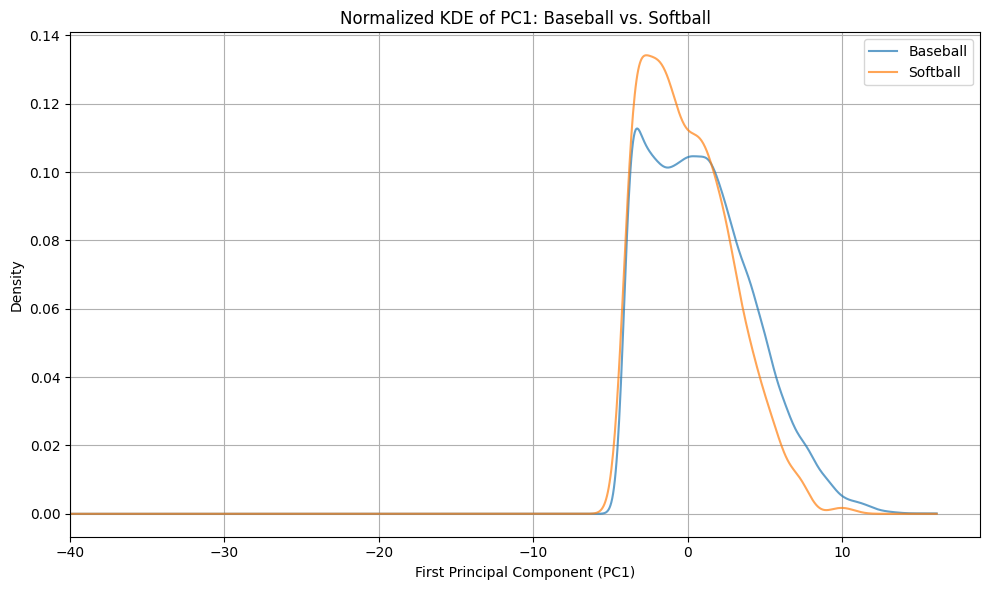

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- Replace with your actual data ---
# X_Train_p2: baseball training features (DataFrame)
# X_softball_c_train: softball training features (DataFrame)
# Both should have the same feature columns

# 1. Combine and standardize
#scaler = StandardScaler()
#X_all = pd.concat([X_Train_p2, X_softball_c_train], axis=0)
#X_all_scaled = scaler.fit_transform(X_all)

# --- STEP 2: PCA on baseball data only ---
pca = PCA(n_components=2)
X_softball_pca = pca.fit_transform(X_Train_p_W2)

# --- STEP 3: Project softball data using baseball PCA model ---
X_baseball_pca = pca.transform(X_Train_p2)


# 3. PCA on baseball
'''pca = PCA(n_components=2)
X_baseball_pca = pca.fit_transform(X_Train_p2)
X_softball_pca = pca.transform(X_Train_p_W2)'''

# 4. Extract PC1
baseball_pc1 = X_baseball_pca[:, 1]
softball_pc1 = X_softball_pca[:, 1]

# 5. Kernel Density Estimation and normalization
x_grid = np.linspace(-40, max(baseball_pc1.max(), softball_pc1.max()), 1000)

kde_baseball = gaussian_kde(baseball_pc1)
kde_softball = gaussian_kde(softball_pc1)

density_baseball = kde_baseball(x_grid)
density_softball = kde_softball(x_grid)

# Normalize to integrate to 1
density_baseball /= np.trapz(density_baseball, x_grid)
density_softball /= np.trapz(density_softball, x_grid)

# 6. Plot
plt.figure(figsize=(10, 6))
plt.plot(x_grid, density_baseball, label="Baseball", alpha=0.7)
plt.plot(x_grid, density_softball, label="Softball", alpha=0.7)
plt.title("Normalized KDE of PC1: Baseball vs. Softball")
plt.xlabel("First Principal Component (PC1)")
plt.ylabel("Density")
plt.xlim(left=-40)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[link text](https://)Next I used those same pca thansformations on the baseball data and created a scatterplot of both on the same graph.

Finally, I selected the 70% of baseball observations that were closest to the "center" of the softball pca bivariate distribution. You can see that there is alot of "noise" in the baseball data, so this was my way of filtering only the most relevant baseball observations to include as the source domain data.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import plotly.express as px
import plotly.graph_objects as go

# ------------------------------------------------------------
# Inputs:
# - X_Train_p2:  baseball training features (DataFrame, chronologically prepped)
# - X_Train_p_W2: softball training features (DataFrame), same columns/order as X_Train_p2
# - coverage: desired probability mass for the softball HDR (e.g., 0.90 for 90%)
# ------------------------------------------------------------
coverage = 0.7  # <- user-desired region of maximum probability

# 1) PCA on baseball only; then project softball
pca = PCA(n_components=2, random_state=42)
X_baseball_pca = pca.fit_transform(X_Train_p2)
X_softball_pca = pca.transform(X_Train_p_W2)

# 2) Build scatter DataFrame (for Plotly)
df_plot = pd.DataFrame({
    "PC1": np.concatenate([X_baseball_pca[:, 0], X_softball_pca[:, 0]]),
    "PC2": np.concatenate([X_baseball_pca[:, 1], X_softball_pca[:, 1]]),
    "Domain": (["Baseball"] * len(X_baseball_pca)) + (["Softball"] * len(X_softball_pca)),
})

# 3) Softball 2D KDE on (PC1, PC2)
xs, ys = X_softball_pca[:, 0], X_softball_pca[:, 1]
kde2d = gaussian_kde(np.vstack([xs, ys]))

# ---- Compute an HDR threshold 'lam' so that area where density >= lam contains 'coverage' mass
# Make a grid in the softball PCA space (clip to central quantiles for stability)
x_lo, x_hi = np.percentile(xs, [1, 99])
y_lo, y_hi = np.percentile(ys, [1, 99])
# pad a bit
pad_x = 0.1 * (x_hi - x_lo) if x_hi > x_lo else 1.0
pad_y = 0.1 * (y_hi - y_lo) if y_hi > y_lo else 1.0
x_grid = np.linspace(x_lo - pad_x, x_hi + pad_x, 200)
y_grid = np.linspace(y_lo - pad_y, y_hi + pad_y, 200)
Xg, Yg = np.meshgrid(x_grid, y_grid)
Z = kde2d(np.vstack([Xg.ravel(), Yg.ravel()])).reshape(Xg.shape)

dx = x_grid[1] - x_grid[0]
dy = y_grid[1] - y_grid[0]
Z_flat = Z.ravel()
order = np.argsort(Z_flat)[::-1]
cdf = np.cumsum(Z_flat[order]) * dx * dy
idx = np.searchsorted(cdf, coverage)
lam = Z_flat[order[idx]] if idx < len(Z_flat) else Z_flat[order[-1]]

# 4) Baseball points inside HDR (by definition: density >= lam under softball KDE)
xb, yb = X_baseball_pca[:, 0], X_baseball_pca[:, 1]
dens_baseball = kde2d(np.vstack([xb, yb]))
inside_hdr_mask = dens_baseball >= lam

# Produce DataFrame of the original baseball training rows inside HDR
if isinstance(X_Train_p2, pd.DataFrame):
    baseball_in_hdr = X_Train_p2.loc[inside_hdr_mask].copy()
else:
    # If X_Train_p2 is a NumPy array, wrap it in a DataFrame temporarily
    baseball_in_hdr = pd.DataFrame(X_Train_p2[inside_hdr_mask])

# Add helpful diagnostics (optional)
baseball_in_hdr["PC1"] = xb[inside_hdr_mask]
baseball_in_hdr["PC2"] = yb[inside_hdr_mask]
baseball_in_hdr["softball_kde"] = dens_baseball[inside_hdr_mask]

print(f"Baseball rows inside the {int(coverage*100)}% HDR: {inside_hdr_mask.sum()} / {len(inside_hdr_mask)}")

# 5) Plotly scatter + overlay the softball density contours (filled from lam upward)
fig = px.scatter(
    df_plot, x="PC1", y="PC2", color="Domain",
    title=f"PCA Scatter with Softball KDE HDR (≥ {int(coverage*100)}% mass)",
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
    opacity=0.7, template="plotly_white"
)

# Add filled contour for softball density (region >= lam)
fig.add_trace(go.Contour(
    x=x_grid,
    y=y_grid,
    z=Z,                           # Plotly expects z[y, x]-like 2D array; our shape matches (len(y), len(x))
    contours=dict(
        start=lam, end=float(Z.max()), size=(float(Z.max()) - float(lam)) / 5,
        coloring="heatmap", showlabels=False
    ),
    showscale=False,
    opacity=0.45,
    name=f"Softball KDE ≥ HDR threshold"
))

# Optional: add a thin boundary line exactly at lam (the HDR boundary)
fig.add_trace(go.Contour(
    x=x_grid, y=y_grid, z=Z,
    contours=dict(start=float(lam), end=float(lam), size=1e-9, coloring="lines", showlabels=False),
    line=dict(color="black", width=2),
    showscale=False,
    name=f"{int(coverage*100)}% HDR boundary"
))

fig.update_layout(legend=dict(itemsizing="constant"))
fig.show()

# 'baseball_in_hdr' now holds the baseball training rows that fall within the softball HDR.
# You can proceed to use 'baseball_in_hdr' downstream.


Baseball rows inside the 70% HDR: 12085 / 18332


In [ ]:
X_baseball_filtered = baseball_in_hdr.iloc[:,:-3]

In [ ]:
y_baseball_filtered = y_baseball_train[baseball_in_hdr.index]

In [ ]:
# --- Step 3: Filter based on PC1 < 0 and PC2 < 100 ---
#mask = (X_baseball_pca[:, 0] < 0) & (X_baseball_pca[:, 1] < 100)

# --- Step 4: Get the original rows that satisfy the mask ---
#X_baseball_filtered = X_Train_p2[mask]
#y_baseball_filtered = y_baseball_train[mask]
# --- Step 5: View or save result ---
#X_baseball_filtered  # or use .to_csv(...) to save

### Creating Baseball Models on the Reduced Data

Classifiers that are built on the newly filtered baseball train data are tested on teh baseball test data. A model that generalizes well with strong precision and recall is a good candidate for domain adaptation. Let's try a few.

In [ ]:
'''
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, ConfusionMatrixDisplay)

# Define the XGBoost model
xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')

# Define the hyperparameters to tune
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define the k-fold cross-validation strategy
cv_strategy_xgb = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Instantiate GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb, cv=cv_strategy_xgb, scoring='f1')

# Fit GridSearchCV to the training data
grid_search_xgb.fit(X_baseball_filtered, y_baseball_filtered)

# Store the best parameters and best estimator
best_params_xgb = grid_search_xgb.best_params_
best_estimator_xgb = grid_search_xgb.best_estimator_

print("Best Hyperparameters for Baseball Data (XGBoost):", best_params_xgb)

# Train the best estimator on the entire training data
best_estimator_xgb.fit(X_baseball_filtered, y_baseball_filtered)

# Predict on the train data
y_pred_xgb_train = best_estimator_xgb.predict(X_baseball_filtered)

# Calculate the confusion matrix
cm_xgb_train = confusion_matrix(y_baseball_filtered, y_pred_xgb_train, labels=None, sample_weight=None, normalize=None)

# Calculate evaluation metrics
accuracy_xgb_train = accuracy_score(y_baseball_filtered, y_pred_xgb_train)
precision_xgb_train = precision_score(y_baseball_filtered, y_pred_xgb_train)
recall_xgb_train= recall_score(y_baseball_filtered, y_pred_xgb_train)
f1_xgb_train = f1_score(y_baseball_filtered, y_pred_xgb_train)

# Print the results
print("\nConfusion Matrix - Train (Baseball Data with XGBoost):")
disp = ConfusionMatrixDisplay(cm_xgb_train, display_labels=None)
disp.plot()

print("\nEvaluation Metrics (Baseball Data with XGBoost):")
print(f"Accuracy: {accuracy_xgb_train:.4f}")
print(f"Precision: {precision_xgb_train:.4f}")
print(f"Recall: {recall_xgb_train:.4f}")
print(f"F1-score: {f1_xgb_train:.4f}")

print("______________________________________________________________________")

# Predict on the test data
y_pred_xgb = best_estimator_xgb.predict(X_Test_p2)

# Calculate the confusion matrix
cm_xgb = confusion_matrix(y_baseball_test, y_pred_xgb, labels=None, sample_weight=None, normalize=None)

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_baseball_test, y_pred_xgb)
precision_xgb = precision_score(y_baseball_test, y_pred_xgb)
recall_xgb = recall_score(y_baseball_test, y_pred_xgb)
f1_xgb = f1_score(y_baseball_test, y_pred_xgb)

# Print the results
print("\nConfusion Matrix - Test (Baseball Data with XGBoost):")
disp = ConfusionMatrixDisplay(cm_xgb, display_labels=None)
disp.plot()

print("\nEvaluation Metrics (Baseball Data with XGBoost):")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-score: {f1_xgb:.4f}")
'''

'\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import GridSearchCV, StratifiedKFold\nfrom sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,\n                             recall_score, f1_score, ConfusionMatrixDisplay)\n\n# Define the XGBoost model\nxgb_clf = XGBClassifier(random_state=42, eval_metric=\'logloss\')\n\n# Define the hyperparameters to tune\nparam_grid_xgb = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [3, 5, 7],\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'subsample\': [0.8, 1.0],\n    \'colsample_bytree\': [0.8, 1.0]\n}\n\n# Define the k-fold cross-validation strategy\ncv_strategy_xgb = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)\n\n# Instantiate GridSearchCV\ngrid_search_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb, cv=cv_strategy_xgb, scoring=\'f1\')\n\n# Fit GridSearchCV to the training data\ngrid_search_xgb.fit(X_baseball_filtered, y_baseball_filtered)\n\n# Store the be

Best Hyperparameters for Baseball Data (Logistic Regression): {'C': 0.1, 'penalty': 'l2'}

Confusion Matrix - Train (Baseball Data with Logistic Regression):

Evaluation Metrics (Baseball Data with Logistic Regression):
Accuracy: 0.5959
Precision: 0.6107
Recall: 0.5781
F1-score: 0.5939
______________________________________________________________________

Confusion Matrix - Test (Baseball Data with Logistic Regression):

Evaluation Metrics (Baseball Data with Logistic Regression):
Accuracy: 0.6285
Precision: 0.3098
Recall: 0.5861
F1-score: 0.4054


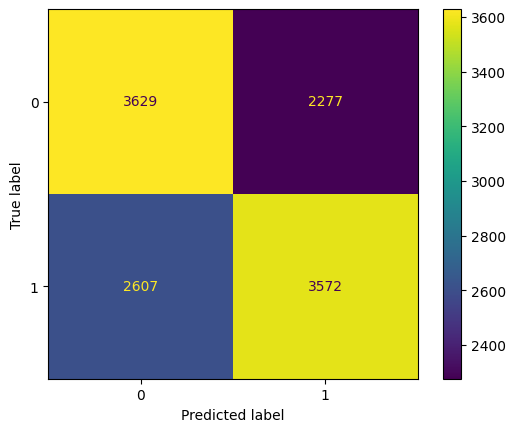

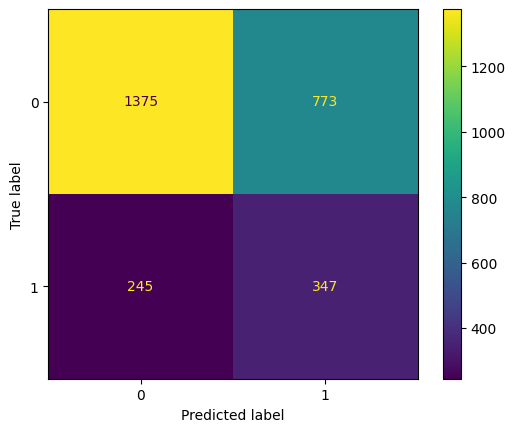

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, ConfusionMatrixDisplay)

# --- Step 1: Define the Logistic Regression model ---
logreg_clf = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

# --- Step 2: Define hyperparameter grid ---
param_grid_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100]  # Inverse regularization strength
}

# --- Step 3: Define cross-validation strategy ---
cv_strategy_logreg = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Step 4: Instantiate GridSearchCV ---
grid_search_logreg = GridSearchCV(
    estimator=logreg_clf,
    param_grid=param_grid_logreg,
    cv=cv_strategy_logreg,
    scoring='f1',
    n_jobs=-1
)

# --- Step 5: Fit to training data ---
grid_search_logreg.fit(X_baseball_filtered, y_baseball_filtered)

# --- Step 6: Store best estimator and params ---
best_params_logreg = grid_search_logreg.best_params_
best_estimator_logreg = grid_search_logreg.best_estimator_

print("Best Hyperparameters for Baseball Data (Logistic Regression):", best_params_logreg)

# --- Step 7: Train best estimator on full training data ---
best_estimator_logreg.fit(X_baseball_filtered, y_baseball_filtered)

# --- Step 8: Evaluate on training data ---
y_pred_train = best_estimator_logreg.predict(X_baseball_filtered)
cm_train = confusion_matrix(y_baseball_filtered, y_pred_train)

accuracy_train = accuracy_score(y_baseball_filtered, y_pred_train)
precision_train = precision_score(y_baseball_filtered, y_pred_train)
recall_train = recall_score(y_baseball_filtered, y_pred_train)
f1_train = f1_score(y_baseball_filtered, y_pred_train)

print("\nConfusion Matrix - Train (Baseball Data with Logistic Regression):")
ConfusionMatrixDisplay(cm_train).plot()

print("\nEvaluation Metrics (Baseball Data with Logistic Regression):")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-score: {f1_train:.4f}")

print("______________________________________________________________________")

# --- Step 9: Predict on test data ---
y_pred_test = best_estimator_logreg.predict(X_Test_p2)
cm_test = confusion_matrix(y_baseball_test, y_pred_test)

accuracy_test = accuracy_score(y_baseball_test, y_pred_test)
precision_test = precision_score(y_baseball_test, y_pred_test)
recall_test = recall_score(y_baseball_test, y_pred_test)
f1_test = f1_score(y_baseball_test, y_pred_test)

print("\nConfusion Matrix - Test (Baseball Data with Logistic Regression):")
ConfusionMatrixDisplay(cm_test).plot()

print("\nEvaluation Metrics (Baseball Data with Logistic Regression):")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-score: {f1_test:.4f}")



In [ ]:
set(X_Train_p_W2.columns) - set(X_baseball_filtered.columns)

set()


Confusion Matrix - Train (Baseball Data with Naive Bayes):

Evaluation Metrics (Baseball Data with Naive Bayes):
Accuracy: 0.5960
Precision: 0.6056
Recall: 0.6019
F1-score: 0.6037
______________________________________________________________________

Confusion Matrix - Test (Baseball Data with Naive Bayes):

Evaluation Metrics (Baseball Data with Naive Bayes):
Accuracy: 0.6142
Precision: 0.3031
Recall: 0.6047
F1-score: 0.4038


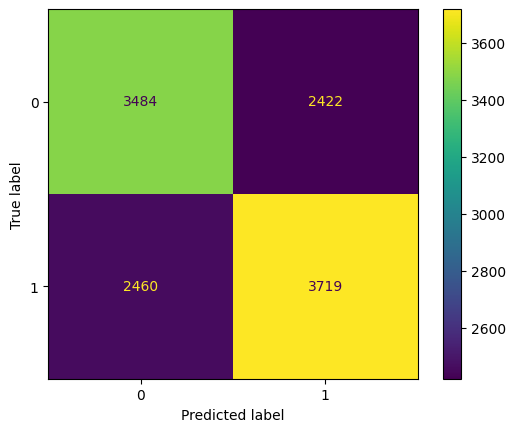

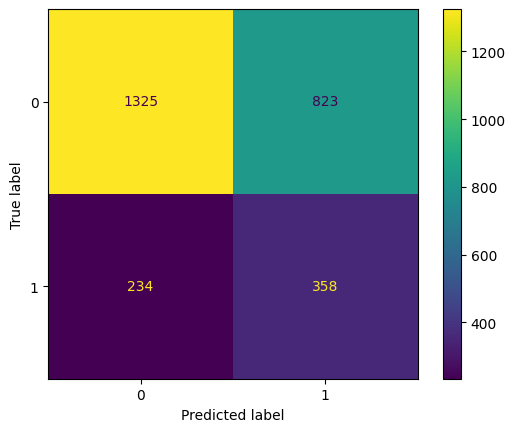

In [ ]:
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, ConfusionMatrixDisplay)

# Define the Naive Bayes model
lr_clf = LogisticRegression()


#print("Best Hyperparameters for Baseball Data (Naive Bayes):", best_params_nb)

# Train the best estimator on the entire training data
lr_clf.fit(X_baseball_filtered, y_baseball_filtered)

# Predict on the train data
y_pred_nb_train = lr_clf.predict(X_baseball_filtered)

# Calculate the confusion matrix
cm_nb_train = confusion_matrix(y_baseball_filtered, y_pred_nb_train)

# Calculate evaluation metrics
accuracy_nb_train = accuracy_score(y_baseball_filtered, y_pred_nb_train)
precision_nb_train = precision_score(y_baseball_filtered, y_pred_nb_train)
recall_nb_train = recall_score(y_baseball_filtered, y_pred_nb_train)
f1_nb_train = f1_score(y_baseball_filtered, y_pred_nb_train)

# Print the results
print("\nConfusion Matrix - Train (Baseball Data with Naive Bayes):")
disp = ConfusionMatrixDisplay(cm_nb_train)
disp.plot()

print("\nEvaluation Metrics (Baseball Data with Naive Bayes):")
print(f"Accuracy: {accuracy_nb_train:.4f}")
print(f"Precision: {precision_nb_train:.4f}")
print(f"Recall: {recall_nb_train:.4f}")
print(f"F1-score: {f1_nb_train:.4f}")

print("______________________________________________________________________")

# Predict on the test data
y_pred_nb = lr_clf.predict(X_Test_p2)

# Calculate the confusion matrix
cm_nb = confusion_matrix(y_baseball_test, y_pred_nb)

# Calculate evaluation metrics
accuracy_nb = accuracy_score(y_baseball_test, y_pred_nb)
precision_nb = precision_score(y_baseball_test, y_pred_nb)
recall_nb = recall_score(y_baseball_test, y_pred_nb)
f1_nb = f1_score(y_baseball_test, y_pred_nb)

# Print the results
print("\nConfusion Matrix - Test (Baseball Data with Naive Bayes):")
disp = ConfusionMatrixDisplay(cm_nb)
disp.plot()

print("\nEvaluation Metrics (Baseball Data with Naive Bayes):")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1-score: {f1_nb:.4f}")


Script to define creation of

In [ ]:
'''
from sklearn.metrics import roc_auc_score

# After you've already done: bw_model.fit(...)

def auc_from_bw(model, X, y_true):
    est = getattr(model, "estimator_", None)
    if est is None:
        raise RuntimeError("Call fit() on the BalancedWeighting model first.")
    # Prefer probabilities; fall back to decision function if needed
    if hasattr(est, "predict_proba"):
        scores = est.predict_proba(X)[:, 1]
    elif hasattr(est, "decision_function"):
        scores = est.decision_function(X)
    else:
        raise AttributeError("Underlying estimator has no predict_proba or decision_function.")
    auc = roc_auc_score(y_true, scores)
    return auc, scores

'''

'\nfrom sklearn.metrics import roc_auc_score\n\n# After you\'ve already done: bw_model.fit(...)\n\ndef auc_from_bw(model, X, y_true):\n    est = getattr(model, "estimator_", None)\n    if est is None:\n        raise RuntimeError("Call fit() on the BalancedWeighting model first.")\n    # Prefer probabilities; fall back to decision function if needed\n    if hasattr(est, "predict_proba"):\n        scores = est.predict_proba(X)[:, 1]\n    elif hasattr(est, "decision_function"):\n        scores = est.decision_function(X)\n    else:\n        raise AttributeError("Underlying estimator has no predict_proba or decision_function.")\n    auc = roc_auc_score(y_true, scores)\n    return auc, scores\n\n'

Let's use the grid search process to identify the best value of the *gamma* parameter.

The following code creates a grid of *gamma* values and estimators and reports the best combination, along with all relevant metrics.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from adapt.instance_based import BalancedWeighting
import matplotlib.pyplot as plt
import warnings

def bw_grid_f1_table(
    est_list, gamma_list,
    Xs, ys,               # SOURCE (e.g., baseball filtered)
    Xt_weight, yt_weight, # TARGET used by BW to compute weights (e.g., softball train)
    Xt_eval, yt_eval,     # EVAL set for scoring (e.g., TV softball)
    random_state=41,
    verbose=0
):
    """
    Returns:
      table_f1  : DataFrame pivot (rows=estimator, cols=gamma) of F1 on Xt_eval
      results   : long-form DataFrame with metrics for each (estimator, gamma)
      best_info : dict with best config and metrics (adds 'roc_auc' and 'pr_auc')
      best_bw   : fitted BalancedWeighting model for the best config

    Side effects:
      - Prints confusion matrix + metrics for best-by-F1 model
      - Plots Precision–Recall curve and prints PR-AUC for the best model
    """
    rows = []
    fitted_models = {}  # (name, gamma) -> model (optional reuse)

    def est_name(e, idx):
        base = e.__class__.__name__
        return f"{base}#{idx}"

    # ---------- Grid sweep ----------
    for i, base_est in enumerate(est_list):
        name_i = est_name(base_est, i)
        for gamma in gamma_list:
            try:
                bw = BalancedWeighting(
                    estimator=clone(base_est),
                    Xt=Xt_weight, yt=yt_weight,
                    gamma=gamma,
                    verbose=verbose,
                    copy=True,
                    random_state=random_state
                )
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    bw.fit(Xs, ys)

                y_pred = bw.predict(Xt_eval)
                cm = confusion_matrix(yt_eval, y_pred)
                acc = accuracy_score(yt_eval, y_pred)
                pre = precision_score(yt_eval, y_pred, zero_division=0)
                rec = recall_score(yt_eval, y_pred, zero_division=0)
                f1  = f1_score(yt_eval, y_pred, zero_division=0)
                tn, fp, fn, tp = cm.ravel()
                spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

                rows.append({
                    "estimator": name_i,
                    "gamma": gamma,
                    "f1": f1,
                    "precision": pre,
                    "recall": rec,
                    "specificity": spec,
                    "accuracy": acc
                })
                fitted_models[(name_i, gamma)] = bw

            except Exception as e:
                rows.append({
                    "estimator": name_i, "gamma": gamma,
                    "f1": np.nan, "precision": np.nan, "recall": np.nan,
                    "specificity": np.nan, "accuracy": np.nan,
                    "error": str(e)
                })

    results = pd.DataFrame(rows)
    table_f1 = results.pivot(index="estimator", columns="gamma", values="f1").sort_index()

    # ---------- Pick best by F1 ----------
    idx_best = results["f1"].idxmax()
    best_row = results.loc[idx_best].to_dict()
    best_name = best_row["estimator"]
    best_gamma = best_row["gamma"]

    bw_best = fitted_models.get((best_name, best_gamma))
    if bw_best is None:
        base_est = est_list[int(best_name.split("#")[-1])]
        bw_best = BalancedWeighting(
            estimator=clone(base_est),
            Xt=Xt_weight, yt=yt_weight,
            gamma=best_gamma,
            verbose=verbose,
            copy=True,
            random_state=random_state
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            bw_best.fit(Xs, ys)

    # ---------- Final metrics on Xt_eval ----------
    y_pred = bw_best.predict(Xt_eval)
    cm = confusion_matrix(yt_eval, y_pred)
    acc = accuracy_score(yt_eval, y_pred)
    pre = precision_score(yt_eval, y_pred, zero_division=0)
    rec = recall_score(yt_eval, y_pred, zero_division=0)
    f1  = f1_score(yt_eval, y_pred, zero_division=0)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    print(f"\nBest config by F1: estimator={best_name}, gamma={best_gamma}")
    print("\nConfusion Matrix (best):")
    ConfusionMatrixDisplay(cm).plot()
    print("\nEvaluation Metrics (best):")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {pre:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"Specificity: {spec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # ---------- Scores for ROC AUC + PR curve ----------
    roc_auc = None
    pr_auc = None
    try:
        est_fitted = getattr(bw_best, "estimator_", None)
        if est_fitted is None:
            raise RuntimeError("BalancedWeighting not fitted.")
        if hasattr(est_fitted, "predict_proba"):
            scores = est_fitted.predict_proba(Xt_eval)[:, 1]
        elif hasattr(est_fitted, "decision_function"):
            scores = est_fitted.decision_function(Xt_eval)
        else:
            scores = None

        if scores is not None:
            # ROC AUC
            roc_auc = roc_auc_score(yt_eval, scores)
            print(f"AUC:       {roc_auc:.4f}")

            # Precision–Recall curve + PR-AUC (Average Precision)
            precisions, recalls, _ = precision_recall_curve(yt_eval, scores)
            pr_auc = average_precision_score(yt_eval, scores)
            print(f"PR-AUC:    {pr_auc:.4f}")

            # Plot PR curve
            plt.figure(figsize=(6, 5))
            plt.plot(recalls, precisions, lw=2, label=f"PR curve (AP={pr_auc:.3f})")
            # baseline = positive prevalence
            base = np.mean(yt_eval)
            plt.hlines(base, 0, 1, linestyles="dashed", label=f"Baseline={base:.3f}")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision–Recall Curve (best model)")
            plt.legend(loc="lower left")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("AUC/PR: estimator has no predict_proba/decision_function.")

    except Exception as e:
        print(f"AUC/PR computation skipped due to error: {e}")

    best_info = {
        "estimator": best_name,
        "gamma": best_gamma,
        "metrics": {
            "accuracy": acc, "precision": pre, "recall": rec,
            "specificity": spec, "f1": f1,
            "roc_auc": roc_auc, "pr_auc": pr_auc
        },
        "confusion_matrix": cm
    }
    return table_f1, results, best_info, bw_best



Best config by F1: estimator=LogisticRegression#3, gamma=0.05

Confusion Matrix (best):

Evaluation Metrics (best):
Accuracy:  0.5744
Precision: 0.2331
Recall:    0.4810
Specificity: 0.5981
F1-score:  0.3140
AUC:       0.5518
PR-AUC:    0.2701


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



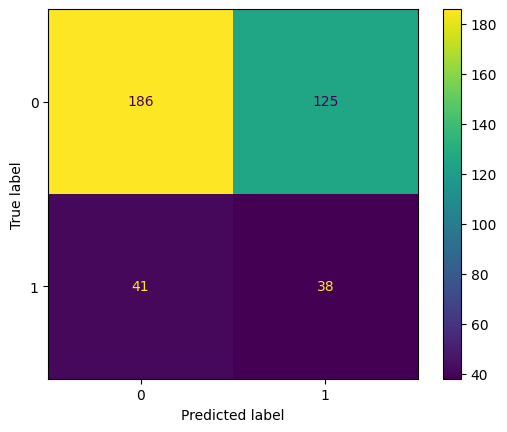

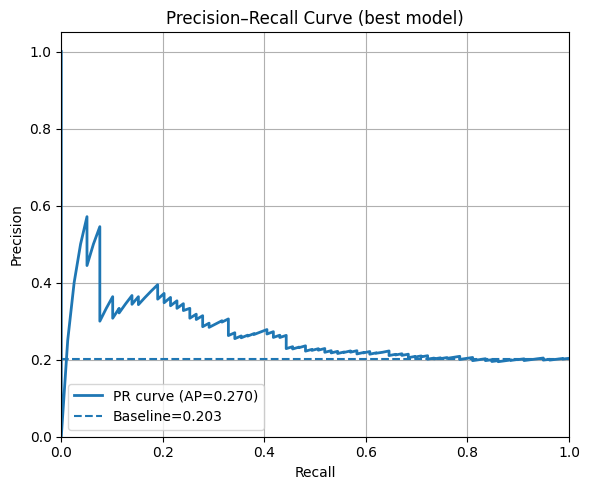


F1 table (rows=estimator, cols=gamma):
gamma                               0.05    0.12    0.19    0.26    0.33  \
estimator                                                                  
HistGradientBoostingClassifier#1  0.2593  0.2444  0.2381  0.2313  0.2336   
LogisticRegression#0              0.3091  0.3005  0.2994  0.2345  0.2063   
LogisticRegression#2              0.3045  0.2967  0.2947  0.2994  0.2568   
LogisticRegression#3              0.3140  0.3033  0.3037  0.3012  0.2621   
LogisticRegression#4              0.3091  0.3005  0.2994  0.2345  0.2063   

gamma                               0.40    0.47    0.54    0.61    0.68  \
estimator                                                                  
HistGradientBoostingClassifier#1  0.2276  0.1404  0.1553  0.1714  0.0879   
LogisticRegression#0              0.1947  0.1923  0.1414  0.1290  0.0698   
LogisticRegression#2              0.2308  0.2105  0.1923  0.1800  0.1304   
LogisticRegression#3              0.2222  0.196

In [ ]:
# Your lists
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
rf = RandomForestClassifier()
hg = HistGradientBoostingClassifier()
lr = LogisticRegression()
est = [lr, hg, logreg_clf, best_estimator_logreg, lr_clf,]
#g = [0.00005, 0.05, 0.2, 0.5, 0.9, 0.99]

#est = [logreg_clf]
g = np.arange(0.05,0.9995,0.07)

table_f1, results_long, best_info, best_model = bw_grid_f1_table(
    est_list=est,
    gamma_list=g,
    Xs=X_baseball_filtered, ys=y_baseball_filtered,   # source
    Xt_weight=X_Train_p_W2, yt_weight=y_softball_c_train,  # target for weighting
    Xt_eval=X_Test_p_W2, yt_eval=y_softball_c_test,       # TV softball set to evaluate
    random_state=41,
    verbose=0
)

print("\nF1 table (rows=estimator, cols=gamma):")
print(table_f1.round(4))

print("\nTop 5 rows of detailed results:")
print(results_long.sort_values('f1', ascending=False).head())
